In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No willr CNN Images Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-noncyclic Stocks

## kweichow Moutai Co., Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


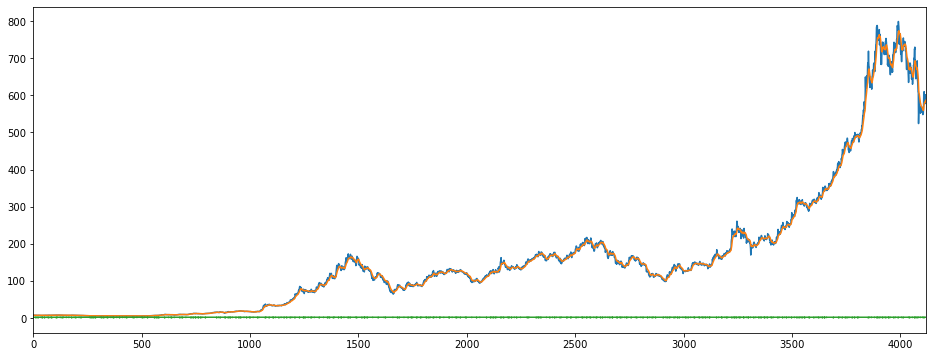

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0

In [8]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [9]:
#willr_data = np.array(#willr_data)
#willr_data.shape

In [10]:
price_data = np.array(price_data)
price_data.shape

(4106, 15, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4106, 15, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4106, 15, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4106, 64, 64, 1)

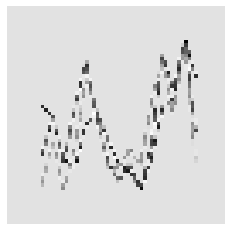

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.396396396396397, 1: 7.497716894977169, 2: 0.3661092530657748}
Epoch 1/200
 1/26 [>.............................] - ETA: 0s - loss: 0.6169 - accuracy: 0.6250 - mse: 5.6219 - weighted_accuracy: 0.2370 - weighted_mse: 7.1668WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 25ms/step - loss: 0.2541 - accuracy: 0.3270 - mse: 1.7718 - weighted_accuracy: 0.3352 - weighted_mse: 1.8908 - val_loss: 0.1744 - val_accuracy: 0.9100 - val_mse: 0.8717 - val_weighted_accuracy: 0.9100 - val_weighted_mse: 0.8717
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2058 - accuracy: 0.3085 - mse: 1.2294 - weighted_accuracy: 0.3293 - weighted_mse: 1.2351 - val_loss: 0.1937 - val_accuracy: 0.2056 - val

Epoch 27/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1983 - accuracy: 0.2707 - mse: 1.1899 - weighted_accuracy: 0.3620 - weighted_mse: 1.1779 - val_loss: 0.1954 - val_accuracy: 0.0657 - val_mse: 1.0547 - val_weighted_accuracy: 0.0657 - val_weighted_mse: 1.0547
Epoch 28/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1983 - accuracy: 0.2622 - mse: 1.2177 - weighted_accuracy: 0.3804 - weighted_mse: 1.1963 - val_loss: 0.1949 - val_accuracy: 0.0791 - val_mse: 0.9501 - val_weighted_accuracy: 0.0791 - val_weighted_mse: 0.9501
Epoch 29/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1985 - accuracy: 0.2546 - mse: 1.1782 - weighted_accuracy: 0.3409 - weighted_mse: 1.1759 - val_loss: 0.1979 - val_accuracy: 0.0596 - val_mse: 0.9854 - val_weighted_accuracy: 0.0596 - val_weighted_mse: 0.9854
Epoch 30/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1968 - accuracy: 0.2707 - mse: 1.2150 - weighted_accuracy: 0.3643 - w

Epoch 56/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1797 - accuracy: 0.1556 - mse: 1.2949 - weighted_accuracy: 0.5359 - weighted_mse: 1.2674 - val_loss: 0.1982 - val_accuracy: 0.0718 - val_mse: 1.0683 - val_weighted_accuracy: 0.0718 - val_weighted_mse: 1.0683
Epoch 57/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1812 - accuracy: 0.1611 - mse: 1.3132 - weighted_accuracy: 0.5053 - weighted_mse: 1.2460 - val_loss: 0.1979 - val_accuracy: 0.0693 - val_mse: 1.0979 - val_weighted_accuracy: 0.0693 - val_weighted_mse: 1.0979
Epoch 58/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1801 - accuracy: 0.1556 - mse: 1.2849 - weighted_accuracy: 0.5185 - weighted_mse: 1.2447 - val_loss: 0.1985 - val_accuracy: 0.0693 - val_mse: 1.0471 - val_weighted_accuracy: 0.0693 - val_weighted_mse: 1.0471
Epoch 59/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1805 - accuracy: 0.1717 - mse: 1.2998 - weighted_accuracy: 0.5072 - 

Epoch 85/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1686 - accuracy: 0.1535 - mse: 1.4457 - weighted_accuracy: 0.5501 - weighted_mse: 1.3937 - val_loss: 0.2022 - val_accuracy: 0.1156 - val_mse: 1.1085 - val_weighted_accuracy: 0.1156 - val_weighted_mse: 1.1085
Epoch 86/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1646 - accuracy: 0.1568 - mse: 1.3960 - weighted_accuracy: 0.5750 - weighted_mse: 1.3480 - val_loss: 0.2032 - val_accuracy: 0.1217 - val_mse: 1.1664 - val_weighted_accuracy: 0.1217 - val_weighted_mse: 1.1664
Epoch 87/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1669 - accuracy: 0.1638 - mse: 1.4453 - weighted_accuracy: 0.5797 - weighted_mse: 1.4006 - val_loss: 0.1990 - val_accuracy: 0.1144 - val_mse: 1.2106 - val_weighted_accuracy: 0.1144 - val_weighted_mse: 1.2106
Epoch 88/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1656 - accuracy: 0.1681 - mse: 1.3368 - weighted_accuracy: 0.5811 - 

Epoch 114/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1514 - accuracy: 0.2092 - mse: 1.5598 - weighted_accuracy: 0.6287 - weighted_mse: 1.5547 - val_loss: 0.1989 - val_accuracy: 0.1910 - val_mse: 1.3748 - val_weighted_accuracy: 0.1910 - val_weighted_mse: 1.3748
Epoch 115/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1494 - accuracy: 0.2025 - mse: 1.6047 - weighted_accuracy: 0.6541 - weighted_mse: 1.5869 - val_loss: 0.1972 - val_accuracy: 0.1691 - val_mse: 1.3887 - val_weighted_accuracy: 0.1691 - val_weighted_mse: 1.3887
Epoch 116/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1505 - accuracy: 0.2159 - mse: 1.5681 - weighted_accuracy: 0.6375 - weighted_mse: 1.5615 - val_loss: 0.2012 - val_accuracy: 0.1423 - val_mse: 1.4592 - val_weighted_accuracy: 0.1423 - val_weighted_mse: 1.4592
Epoch 117/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1491 - accuracy: 0.2049 - mse: 1.5521 - weighted_accuracy: 0.627

Epoch 143/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1366 - accuracy: 0.3039 - mse: 1.8461 - weighted_accuracy: 0.7041 - weighted_mse: 1.9288 - val_loss: 0.1953 - val_accuracy: 0.2883 - val_mse: 1.7085 - val_weighted_accuracy: 0.2883 - val_weighted_mse: 1.7085
Epoch 144/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1367 - accuracy: 0.2896 - mse: 1.8717 - weighted_accuracy: 0.6904 - weighted_mse: 1.9507 - val_loss: 0.1948 - val_accuracy: 0.2701 - val_mse: 1.5976 - val_weighted_accuracy: 0.2701 - val_weighted_mse: 1.5976
Epoch 145/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1359 - accuracy: 0.3103 - mse: 1.8048 - weighted_accuracy: 0.6958 - weighted_mse: 1.9508 - val_loss: 0.1924 - val_accuracy: 0.2701 - val_mse: 1.5997 - val_weighted_accuracy: 0.2701 - val_weighted_mse: 1.5997
Epoch 146/200
26/26 [==============================] - 0s 11ms/step - loss: 0.1353 - accuracy: 0.3210 - mse: 1.8461 - weighted_accuracy: 0.7084 -

Epoch 172/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1249 - accuracy: 0.4290 - mse: 2.2137 - weighted_accuracy: 0.7328 - weighted_mse: 2.6081 - val_loss: 0.1814 - val_accuracy: 0.3929 - val_mse: 1.8329 - val_weighted_accuracy: 0.3929 - val_weighted_mse: 1.8329
Epoch 173/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1226 - accuracy: 0.4376 - mse: 2.1837 - weighted_accuracy: 0.7403 - weighted_mse: 2.5469 - val_loss: 0.1699 - val_accuracy: 0.4781 - val_mse: 1.8013 - val_weighted_accuracy: 0.4781 - val_weighted_mse: 1.8013
Epoch 174/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1255 - accuracy: 0.4449 - mse: 2.1804 - weighted_accuracy: 0.7430 - weighted_mse: 2.4248 - val_loss: 0.1767 - val_accuracy: 0.4538 - val_mse: 1.9244 - val_weighted_accuracy: 0.4538 - val_weighted_mse: 1.9244
Epoch 175/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1222 - accuracy: 0.4458 - mse: 2.2638 - weighted_accuracy: 0.7583 - 

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16679908335208893
Test accuracy: 0.5267639756202698


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.5333223  -1.5651355  -0.5729209 ]
 [-1.021247   -1.2019241  -0.4576683 ]
 [-1.2704779  -1.1341239  -0.47640443]
 ...
 [-1.0617548  -1.025141   -0.34093916]
 [-0.45039293 -1.9011165  -0.4705146 ]
 [-1.7532243  -0.6398411  -0.6135881 ]]


Counter({0: 219, 2: 455, 1: 148})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 748, 1: 37, 0: 37})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 822
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 27
actual sells but predicted buy: 3
actual predicted sells: 16
actual sells but predicted hold: 18
actual holds but predicted buy: 138
actual holds but predicted sell: 200
actual predicted holds: 410
Percentage buys correct: 18.91891891891892%
Percentage sells correct: 43.24324324324324%
Percentage holds correct: 54.81283422459893%
actual buys: 37
actual sells: 37
actual holds: 748


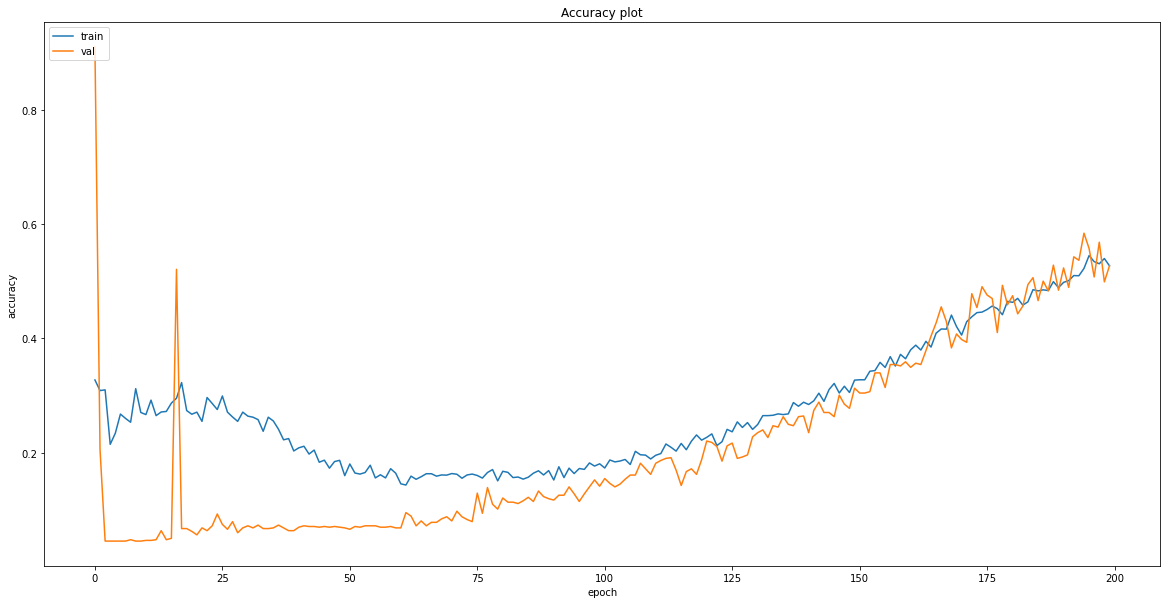

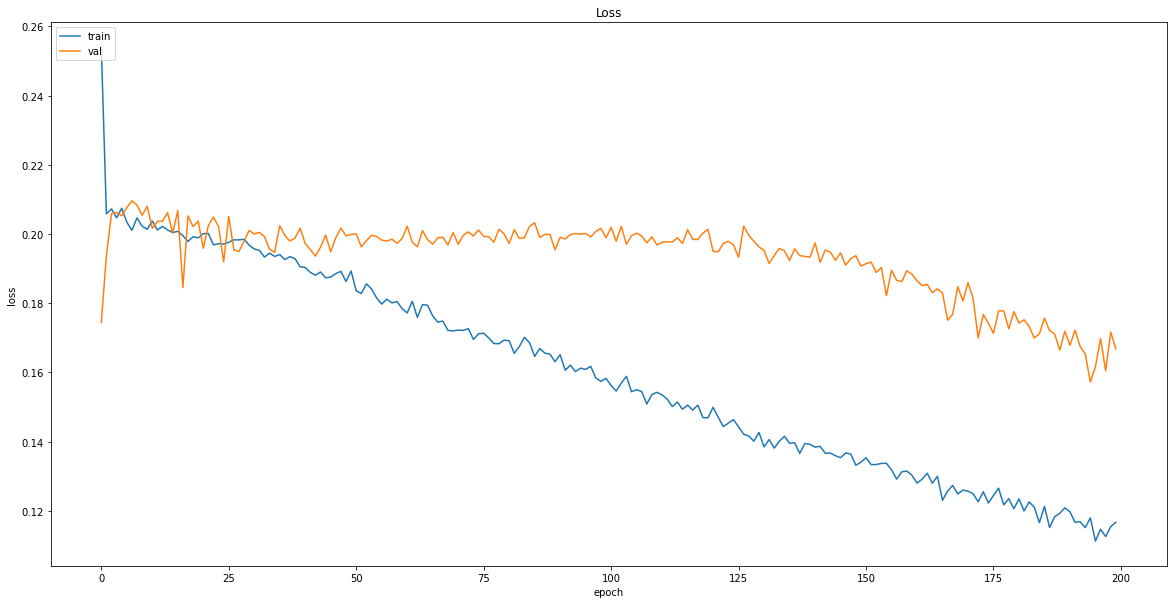

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('moutai_image_cnn_buy_hold_sell_no_willr.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_image_cnn_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


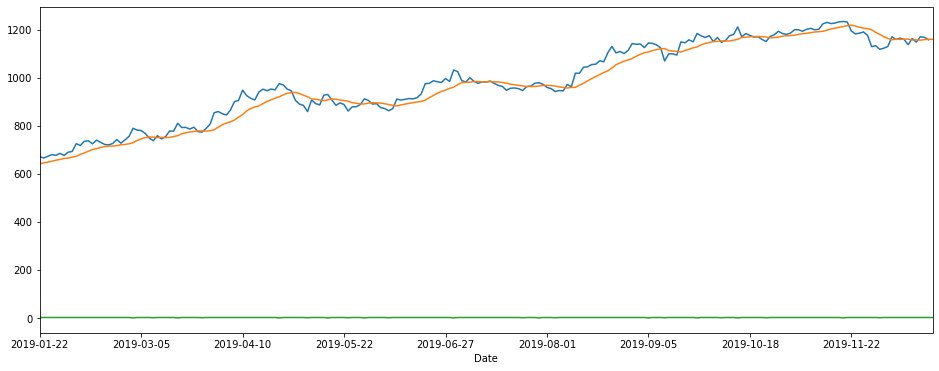

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
# #willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# #data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         #data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         #willr_data.append(#data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         #data_15_willr = #data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         #data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [36]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [37]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 7ms/step - loss: 0.1706 - accuracy: 0.5024 - mean_squared_error: 2.2047 - weighted_accuracy: 0.5024 - weighted_mean_squared_error: 2.2047
Test loss: 0.17061176896095276
Test accuracy: 0.5024154782295227


In [38]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 108, 1: 36, 0: 63})

In [39]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [40]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [41]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-18    740.00000  704.389763 -23.444619  43919901.0     2.0   
2019-02-19    730.76001  709.868261  -6.049880  47694490.0     2.0   
2019-02-20    722.00000  713.082376 -17.677836  44744340.0     2.0   
2019-02-21    720.25000  714.454318 -29.824573  40956103.0     2.0   
2019-02-22    726.01001  715.345962 -32.098776  37971063.0     2.0   

            predictions  actual  
Date                             
2019-02-18            2       2  
2019-02-19            2       2  
2019-02-20            2       2  
2019-02-21            1       2  
2019-02-22            1       2

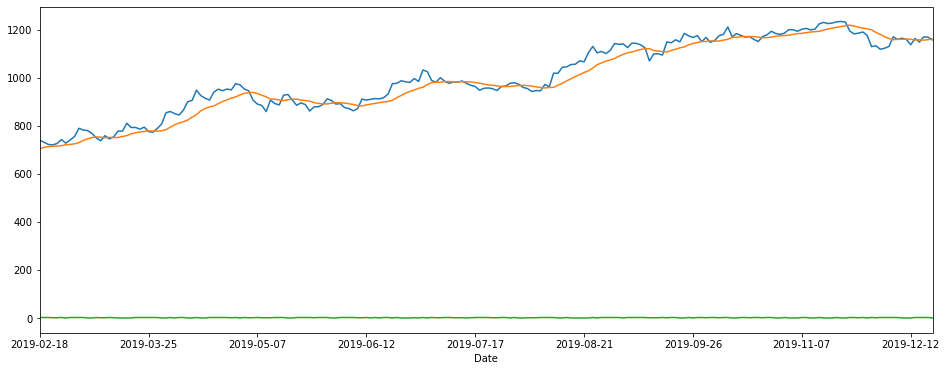

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

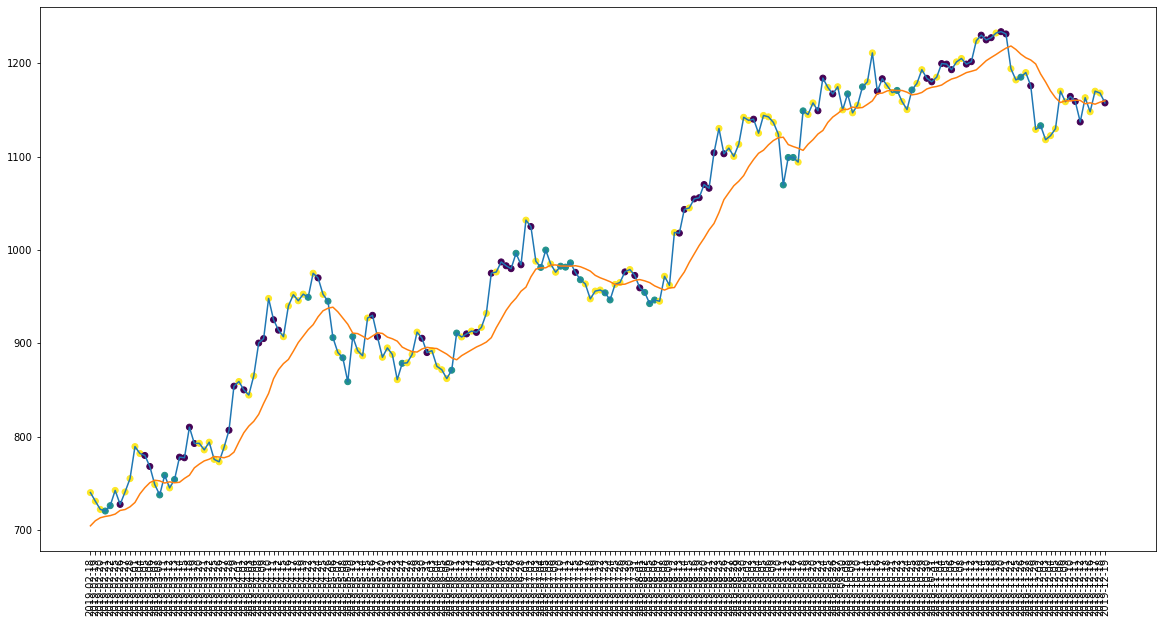

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

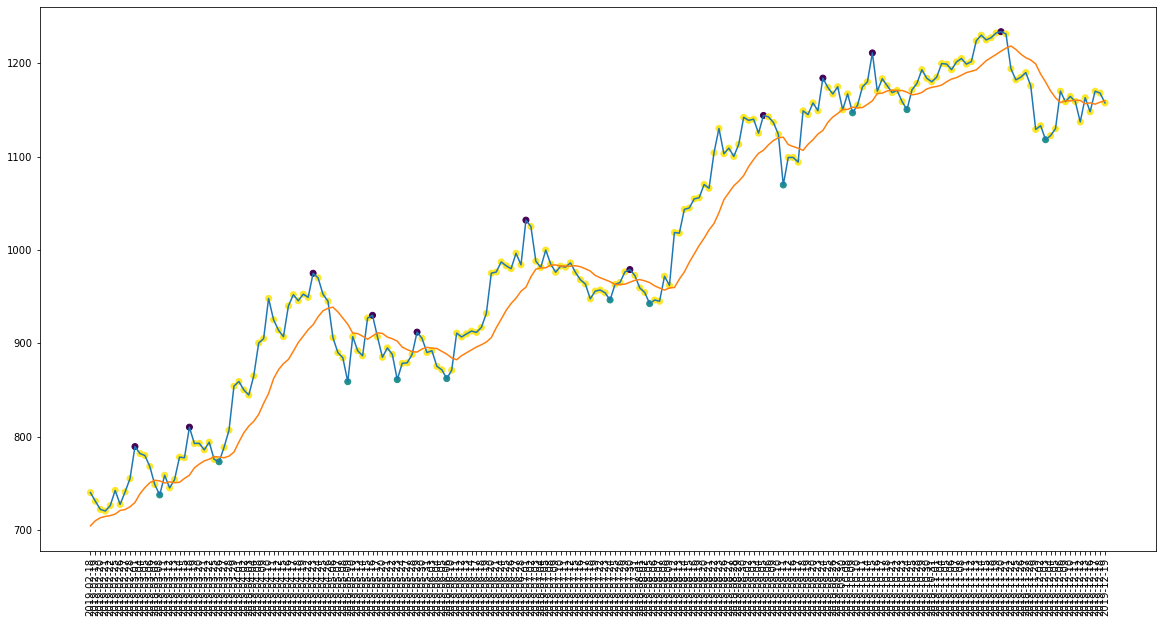

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 7
actual holds but predicted buy: 31
actual holds but predicted sell: 59
actual predicted holds: 95
Percentage buys correct: 45.45454545454545%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 51.351351351351354%
actual buys: 11
actual sells: 11
actual holds: 185


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 52.77777777777778%
Percentage sells correct: 45.16129032258065%
Percentage holds correct: 83.33333333333333%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $720.25
Shares owned at the moment: 13
Cash capital at the moment: $611.0010624999995


Price increase from previously bought: 7.9682770052435625%
Share price: $779.780029296875
Shares owned at the moment: 0
Cash capital at the moment: $10720.26430731201


Share price: $737.5
Shares owned at the moment: 14
Cash capital at the moment: $366.8705573120096


Price increase from previously bought: 5.202219320597168%
Share price: $778.0
Shares owned at the moment: 0
Cash capital at the moment: $11228.91755731201


Share price: $949.2000122070312
Shares owned at the moment: 11
Cash capital at the moment: $759.004122665403


Stop Loss Activated!

Share price: $906.0
Shares owned at the moment: 0
Cash capital at the moment: $10697.597622665402


Share price: $906.0
Shares owned at the moment: 11
Cash capital at the moment: $704.191122665401


Stop Loss Activated!

Share price: $858.8099975585938
Shares owned at the moment: 0
Cash capital at the moment: $10125.122093383785


Share p

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


In [49]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys       correct_sells        correct_holds  \
0       0.502415  45.45454545454545%  36.36363636363637%  51.351351351351354%   

     correct_low_buys  correct_high_sells   correct_mid_holds  \
0  52.77777777777778%  45.16129032258065%  83.33333333333333%   

        Profit gained  buy_n_hold profit  
0  32.86137729614245%  53.5836826651001%

### Recession

In [50]:
logger = []

In [51]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


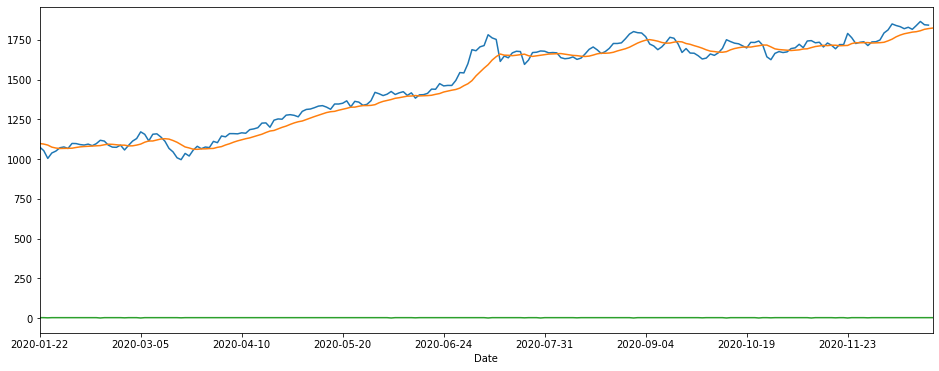

In [52]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [54]:
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [56]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [57]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [58]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 6ms/step - loss: 0.1587 - accuracy: 0.5625 - mean_squared_error: 2.0928 - weighted_accuracy: 0.5625 - weighted_mean_squared_error: 2.0928
Test loss: 0.15868303179740906
Test accuracy: 0.5625


In [59]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 116, 1: 26, 0: 66})

In [60]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [61]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [62]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d       EMA_12   willr_14      OBV_7  labels  \
Date                                                                 
2020-02-19  1096.500000  1082.513705 -22.324305  -423291.0     2.0   
2020-02-20  1118.000000  1084.665443 -12.988283  3281856.0     0.0   
2020-02-21  1112.880005  1089.793836  -4.166667  7962118.0     2.0   
2020-02-24  1087.180054  1093.345554 -10.201830  5068110.0     2.0   
2020-02-25  1074.810059  1092.397016 -40.474836  1203074.0     2.0   

            predictions  actual  
Date                             
2020-02-19            2       2  
2020-02-20            2       0  
2020-02-21            2       2  
2020-02-24            2       2  
2020-02-25            2       2

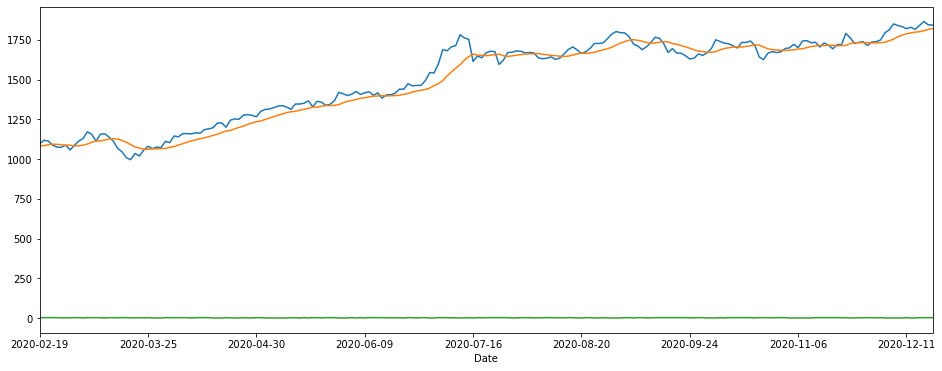

In [63]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

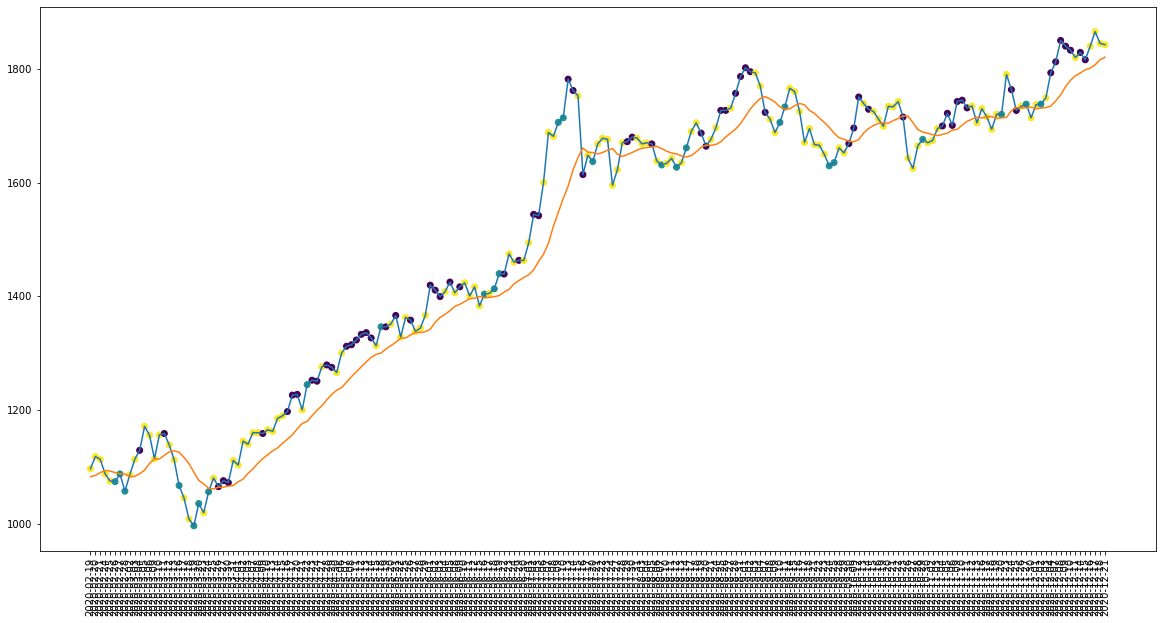

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

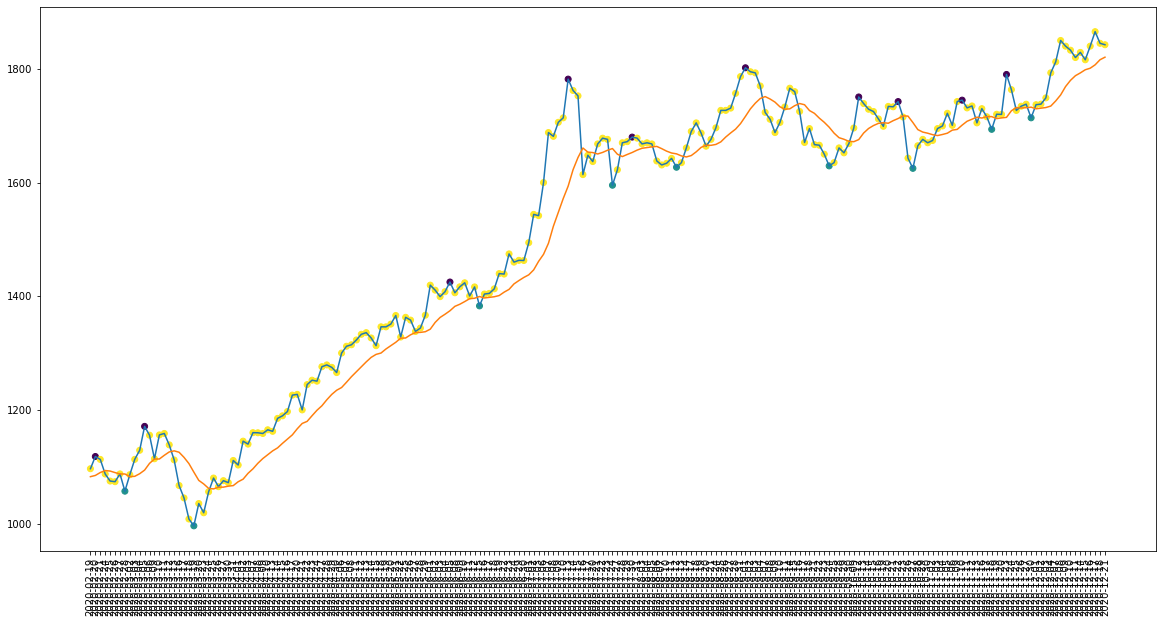

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 22
actual holds but predicted sell: 60
actual predicted holds: 107
Percentage buys correct: 44.44444444444444%
Percentage sells correct: 60.0%
Percentage holds correct: 56.613756613756614%
actual buys: 9
actual sells: 10
actual holds: 189


In [67]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 50.0%
Percentage sells correct: 53.03030303030303%
Percentage holds correct: 85.21739130434783%


In [68]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1073.699951171875
Shares owned at the moment: 9
Cash capital at the moment: $310.1263656616211


Price increase from previously bought: 7.60388183837426%
Share price: $1158.52001953125
Shares owned at the moment: 0
Cash capital at the moment: $10708.133170959472


Share price: $1067.0
Shares owned at the moment: 10
Cash capital at the moment: $8.790670959471754


Stop Loss Activated!

Share price: $1007.989990234375
Shares owned at the moment: 0
Cash capital at the moment: $10060.970848571777


Share price: $996.0
Shares owned at the moment: 10
Cash capital at the moment: $73.5808485717771


Price increase from previously bought: 6.6264603610465045%
Share price: $1064.9200439453123
Shares owned at the moment: 0
Cash capital at the moment: $10693.495986816404


Share price: $1244.5
Shares owned at the moment: 8
Cash capital at the moment: $710.1169868164034


Price increase from previously bought: 5.134744458764895%
Share price: $1312.0
Shares owned at the moment: 0
Cash c

In [69]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


In [70]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys       correct_sells        correct_holds  \
0       0.502415  45.45454545454545%  36.36363636363637%  51.351351351351354%   
1       0.562500  44.44444444444444%               60.0%  56.613756613756614%   

     correct_low_buys  correct_high_sells   correct_mid_holds  \
0  52.77777777777778%  45.16129032258065%  83.33333333333333%   
1               50.0%  53.03030303030303%  85.21739130434783%   

        Profit gained   buy_n_hold profit  
0  32.86137729614245%   53.5836826651001%  
1  36.98065233612054%  66.41259749999998%

### Midea Group

In [71]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


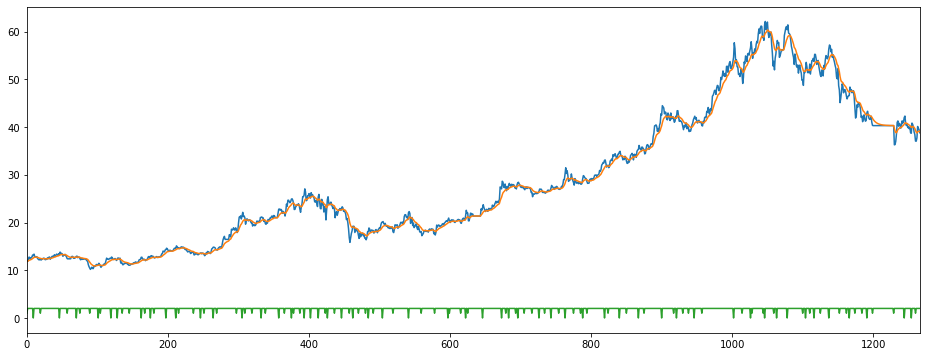

In [72]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [73]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0

In [74]:
# #willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# #data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         #data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         #willr_data.append(#data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         #data_15_willr = #data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         #data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [75]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [76]:
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [78]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(1253, 64, 64, 1)

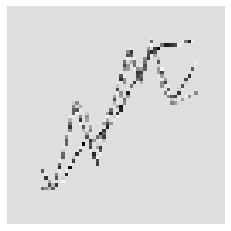

In [79]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [80]:
X = X/255

In [81]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [82]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [83]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [85]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.9523809523809526, 1: 6.816326530612245, 2: 0.36663007683863885}
Epoch 1/200
8/8 [==============================] - 4s 441ms/step - loss: 0.3176 - accuracy: 0.4261 - mse: 2.9536 - weighted_accuracy: 0.3183 - weighted_mse: 2.9588 - val_loss: 0.1871 - val_accuracy: 0.2550 - val_mse: 1.2478 - val_weighted_accuracy: 0.2550 - val_weighted_mse: 1.2478
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.2195 - accuracy: 0.3174 - mse: 1.2216 - weighted_accuracy: 0.3261 - weighted_mse: 1.2601 - val_loss: 0.2018 - val_accuracy: 0.0518 - val_mse: 0.9647 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.9647
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 0.2125 - accuracy: 0.1687 - mse: 1.2299 - weighted_accuracy: 0.3303 - weighted_mse: 1.1363 - val_loss: 0.2119 - val_accuracy: 0.0518 - val_mse: 0.9248 - val_weighted_accuracy: 0.0518 - val_weighted_mse: 0.9248
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.2070 - ac

Epoch 29/200
8/8 [==============================] - 0s 11ms/step - loss: 0.2049 - accuracy: 0.3493 - mse: 1.1973 - weighted_accuracy: 0.3272 - weighted_mse: 1.2296 - val_loss: 0.1957 - val_accuracy: 0.4940 - val_mse: 0.8779 - val_weighted_accuracy: 0.4940 - val_weighted_mse: 0.8779
Epoch 30/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2018 - accuracy: 0.3204 - mse: 1.1233 - weighted_accuracy: 0.3692 - weighted_mse: 1.1273 - val_loss: 0.1978 - val_accuracy: 0.0598 - val_mse: 1.0462 - val_weighted_accuracy: 0.0598 - val_weighted_mse: 1.0462
Epoch 31/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1992 - accuracy: 0.3563 - mse: 1.1438 - weighted_accuracy: 0.3828 - weighted_mse: 1.1055 - val_loss: 0.1779 - val_accuracy: 0.9084 - val_mse: 0.9299 - val_weighted_accuracy: 0.9084 - val_weighted_mse: 0.9299
Epoch 32/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2036 - accuracy: 0.4511 - mse: 1.3296 - weighted_accuracy: 0.3626 - weighted

Epoch 58/200
8/8 [==============================] - 0s 10ms/step - loss: 0.2010 - accuracy: 0.4032 - mse: 1.0914 - weighted_accuracy: 0.3867 - weighted_mse: 1.1311 - val_loss: 0.1891 - val_accuracy: 0.4104 - val_mse: 0.9848 - val_weighted_accuracy: 0.4104 - val_weighted_mse: 0.9848
Epoch 59/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1963 - accuracy: 0.3613 - mse: 1.2130 - weighted_accuracy: 0.3520 - weighted_mse: 1.2281 - val_loss: 0.1906 - val_accuracy: 0.6056 - val_mse: 0.8580 - val_weighted_accuracy: 0.6056 - val_weighted_mse: 0.8580
Epoch 60/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1946 - accuracy: 0.3124 - mse: 1.1270 - weighted_accuracy: 0.3716 - weighted_mse: 1.1479 - val_loss: 0.1931 - val_accuracy: 0.0598 - val_mse: 1.0722 - val_weighted_accuracy: 0.0598 - val_weighted_mse: 1.0722
Epoch 61/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1937 - accuracy: 0.2695 - mse: 1.2674 - weighted_accuracy: 0.4433 - weighted

Epoch 87/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1857 - accuracy: 0.2754 - mse: 1.2160 - weighted_accuracy: 0.5080 - weighted_mse: 1.2203 - val_loss: 0.1890 - val_accuracy: 0.3625 - val_mse: 0.9650 - val_weighted_accuracy: 0.3625 - val_weighted_mse: 0.9650
Epoch 88/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1820 - accuracy: 0.2285 - mse: 1.2388 - weighted_accuracy: 0.5362 - weighted_mse: 1.2701 - val_loss: 0.1993 - val_accuracy: 0.0757 - val_mse: 1.0186 - val_weighted_accuracy: 0.0757 - val_weighted_mse: 1.0186
Epoch 89/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1878 - accuracy: 0.2485 - mse: 1.2200 - weighted_accuracy: 0.5253 - weighted_mse: 1.2117 - val_loss: 0.1932 - val_accuracy: 0.2789 - val_mse: 0.9675 - val_weighted_accuracy: 0.2789 - val_weighted_mse: 0.9675
Epoch 90/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1882 - accuracy: 0.2575 - mse: 1.2777 - weighted_accuracy: 0.4874 - weighted

8/8 [==============================] - 0s 11ms/step - loss: 0.1633 - accuracy: 0.2615 - mse: 1.3305 - weighted_accuracy: 0.5956 - weighted_mse: 1.3384 - val_loss: 0.1974 - val_accuracy: 0.2191 - val_mse: 1.0499 - val_weighted_accuracy: 0.2191 - val_weighted_mse: 1.0499
Epoch 116/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1749 - accuracy: 0.1816 - mse: 1.2713 - weighted_accuracy: 0.5273 - weighted_mse: 1.2391 - val_loss: 0.1993 - val_accuracy: 0.1155 - val_mse: 1.0812 - val_weighted_accuracy: 0.1155 - val_weighted_mse: 1.0812
Epoch 117/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1726 - accuracy: 0.1846 - mse: 1.3455 - weighted_accuracy: 0.5686 - weighted_mse: 1.3714 - val_loss: 0.1950 - val_accuracy: 0.2550 - val_mse: 1.0670 - val_weighted_accuracy: 0.2550 - val_weighted_mse: 1.0670
Epoch 118/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1675 - accuracy: 0.2375 - mse: 1.2782 - weighted_accuracy: 0.5879 - weighted_mse: 1.31

Epoch 144/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1598 - accuracy: 0.2325 - mse: 1.3044 - weighted_accuracy: 0.6153 - weighted_mse: 1.3230 - val_loss: 0.1923 - val_accuracy: 0.2151 - val_mse: 1.1361 - val_weighted_accuracy: 0.2151 - val_weighted_mse: 1.1361
Epoch 145/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1621 - accuracy: 0.2495 - mse: 1.3622 - weighted_accuracy: 0.6075 - weighted_mse: 1.4182 - val_loss: 0.1965 - val_accuracy: 0.2231 - val_mse: 1.0695 - val_weighted_accuracy: 0.2231 - val_weighted_mse: 1.0695
Epoch 146/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1549 - accuracy: 0.2265 - mse: 1.3521 - weighted_accuracy: 0.6581 - weighted_mse: 1.3402 - val_loss: 0.1923 - val_accuracy: 0.2191 - val_mse: 1.1708 - val_weighted_accuracy: 0.2191 - val_weighted_mse: 1.1708
Epoch 147/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1533 - accuracy: 0.2625 - mse: 1.4890 - weighted_accuracy: 0.6380 - weig

Epoch 173/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1496 - accuracy: 0.2725 - mse: 1.5872 - weighted_accuracy: 0.6265 - weighted_mse: 1.6838 - val_loss: 0.1918 - val_accuracy: 0.2948 - val_mse: 1.1461 - val_weighted_accuracy: 0.2948 - val_weighted_mse: 1.1461
Epoch 174/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1549 - accuracy: 0.2884 - mse: 1.3854 - weighted_accuracy: 0.6085 - weighted_mse: 1.3592 - val_loss: 0.1875 - val_accuracy: 0.3227 - val_mse: 1.1627 - val_weighted_accuracy: 0.3227 - val_weighted_mse: 1.1627
Epoch 175/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1461 - accuracy: 0.3184 - mse: 1.4927 - weighted_accuracy: 0.6479 - weighted_mse: 1.6170 - val_loss: 0.1890 - val_accuracy: 0.3147 - val_mse: 1.2281 - val_weighted_accuracy: 0.3147 - val_weighted_mse: 1.2281
Epoch 176/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1479 - accuracy: 0.2934 - mse: 1.5239 - weighted_accuracy: 0.6471 - weig

In [86]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.18739233911037445
Test accuracy: 0.4302788972854614


In [87]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.38755822e+00 -1.50201440e-01 -5.25134087e-01]
 [-3.84524345e-01 -8.54495764e-01 -4.19147551e-01]
 [-9.86266077e-01 -4.03204173e-01 -3.68178040e-01]
 [-7.91186392e-01 -5.82444191e-01 -3.16408336e-01]
 [-1.55444682e+00 -7.07780942e-02 -6.16546690e-01]
 [-7.25726783e-01 -5.20873189e-01 -3.39458406e-01]
 [-1.54335546e+00 -3.81780453e-02 -5.62411666e-01]
 [-5.33460200e-01 -8.15422595e-01 -3.38931561e-01]
 [-1.37886691e+00 -1.55124605e-01 -4.94474590e-01]
 [-4.05420750e-01 -7.69072294e-01 -3.23525280e-01]
 [-7.33784139e-01 -5.58101416e-01 -2.96261430e-01]
 [-1.00716829e+00 -3.62518817e-01 -3.50618720e-01]
 [-1.34469116e+00 -3.95689040e-01 -4.50671673e-01]
 [-3.39108706e-01 -9.30323839e-01 -4.04165924e-01]
 [-6.76206291e-01 -4.88169223e-01 -2.67628461e-01]
 [-8.59701872e-01 -7.18235016e-01 -2.70765781e-01]
 [-2.25502133e+00  1.75919563e-01 -8.66716266e-01]
 [-9.78483200e-01 -3.45615417e-01 -3.45165938e-01]
 [-1.01878333e+00 -5.47981024e-01 -3.33298683e-01]
 [-1.15827990e+00 -2.79083878e-

Counter({1: 105, 0: 43, 2: 103})

In [88]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 228, 1: 13, 0: 10})

In [89]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 251
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 93
actual holds but predicted sell: 40
actual predicted holds: 95
Percentage buys correct: 76.92307692307692%
Percentage sells correct: 30.0%
Percentage holds correct: 41.666666666666664%
actual buys: 13
actual sells: 10
actual holds: 228


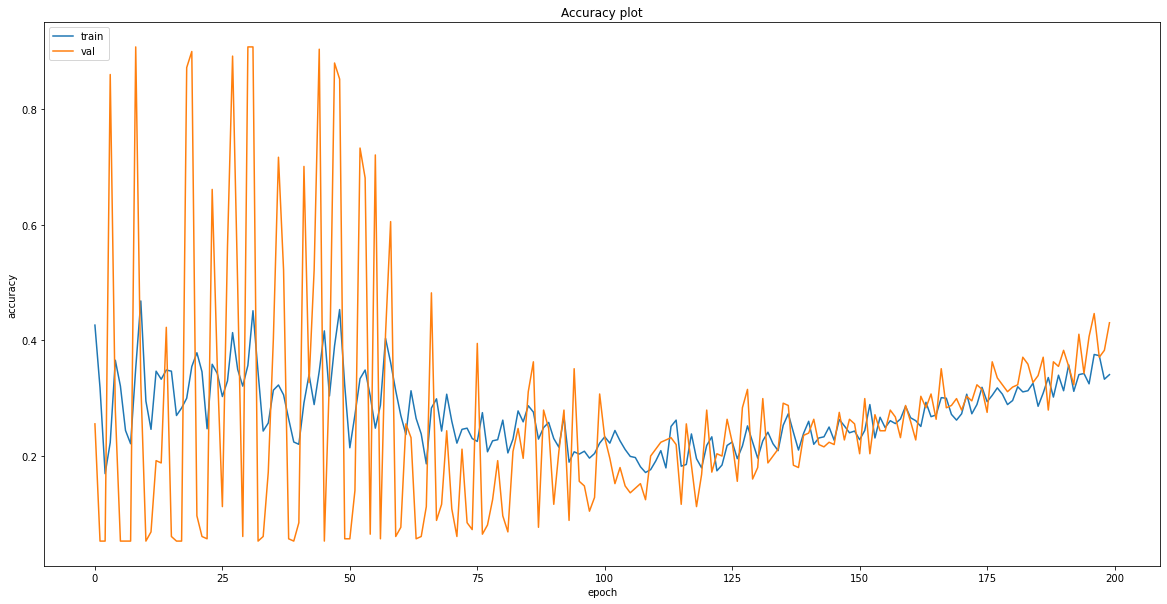

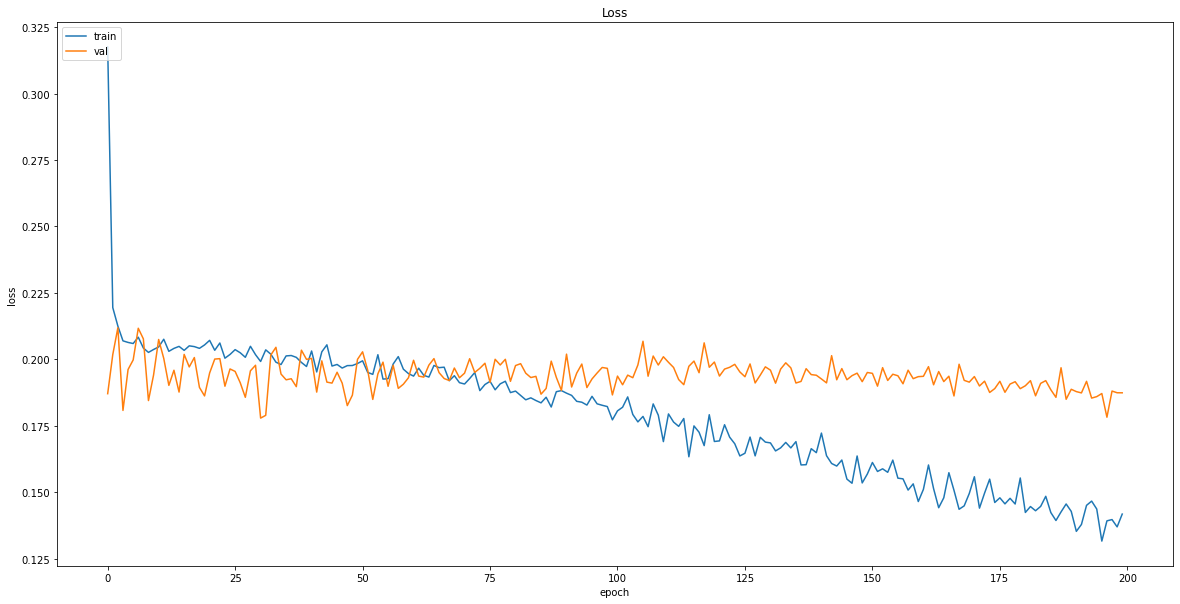

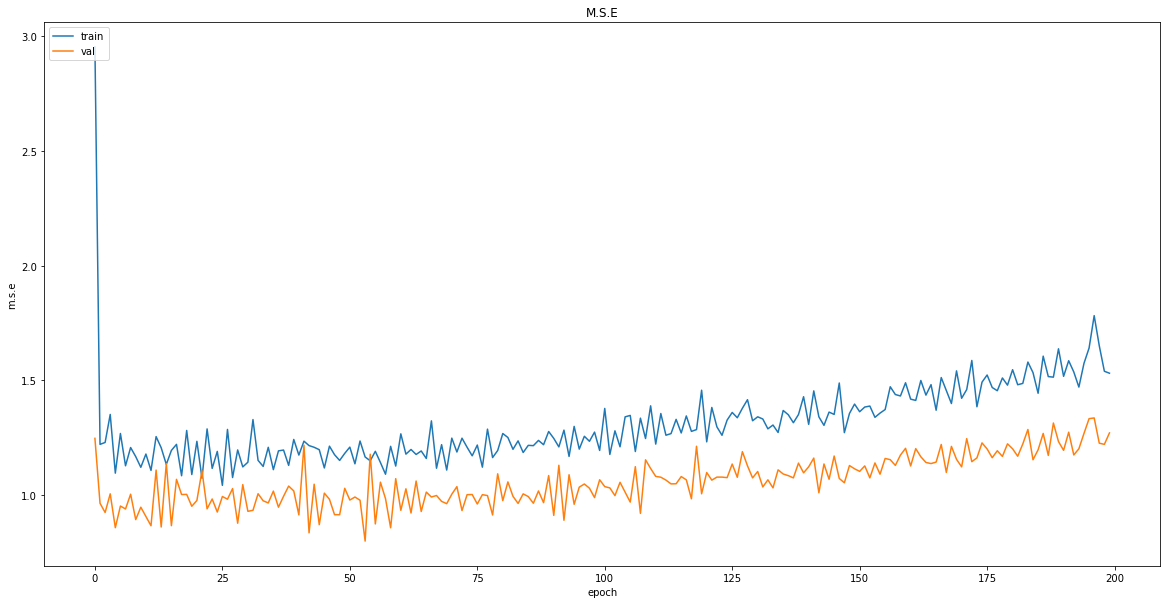

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [91]:
# Save model
model.save("models/{}".format('midea_image_cnn_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/midea_image_cnn_buy_hold_sell_no_willr.model\assets


### Test Performance

#### Non-Recession

In [92]:
logger = []

In [93]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


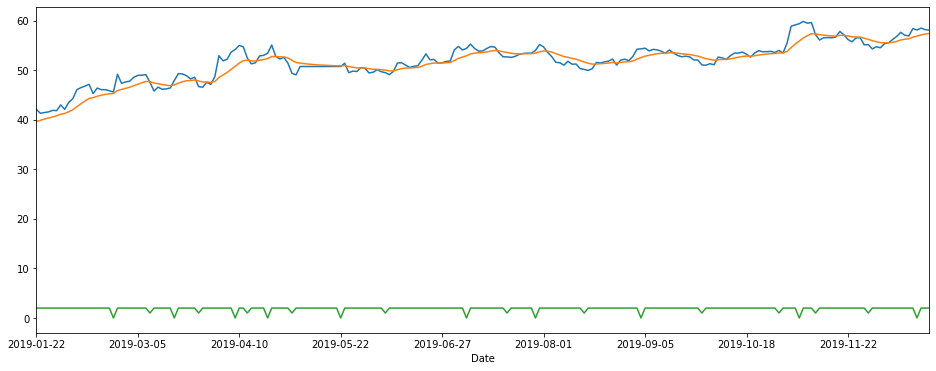

In [94]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [95]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [96]:
# #willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# #data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         #data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         #willr_data.append(#data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         #data_15_willr = #data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         #data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1
        
# #willr_data = np.array(#willr_data)
# price_data = np.array(price_data)
# ema_data = np.array(ema_data)
# obv_data = np.array(obv_data)

In [97]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [99]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [100]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [101]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1847 - accuracy: 0.4493 - mean_squared_error: 1.2555 - weighted_accuracy: 0.4493 - weighted_mean_squared_error: 1.2555
Test loss: 0.1846838891506195
Test accuracy: 0.4492753744125366


In [102]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 88, 1: 87, 0: 32})

In [103]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [104]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [105]:
# df['previous_1d'] = df['previous_1d'].shift(-1)
# df.dropna(inplace=True)
# df = df.iloc[13:]
# df['predictions'] = predictions
# df['actual'] = actual
# df.head()

In [106]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-18    46.400002  44.456141 -30.862341  419918481.0     2.0   
2019-02-19    46.080002  44.755197 -13.767016  452488699.0     2.0   
2019-02-20    46.080002  44.959013 -18.975880  424412835.0     2.0   
2019-02-21    45.860001  45.131473 -18.975880  424412835.0     2.0   
2019-02-22    45.610001  45.243554 -26.174460  382970560.0     2.0   

            predictions  actual  
Date                             
2019-02-18            2       2  
2019-02-19            2       2  
2019-02-20            1       2  
2019-02-21            1       2  
2019-02-22            1       2

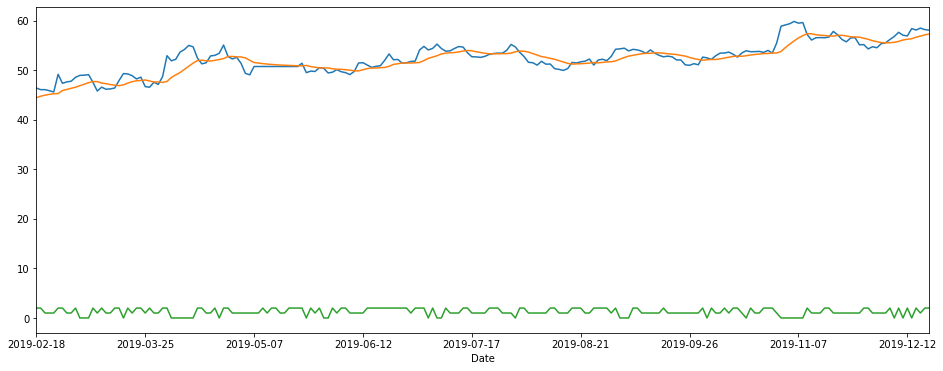

In [107]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

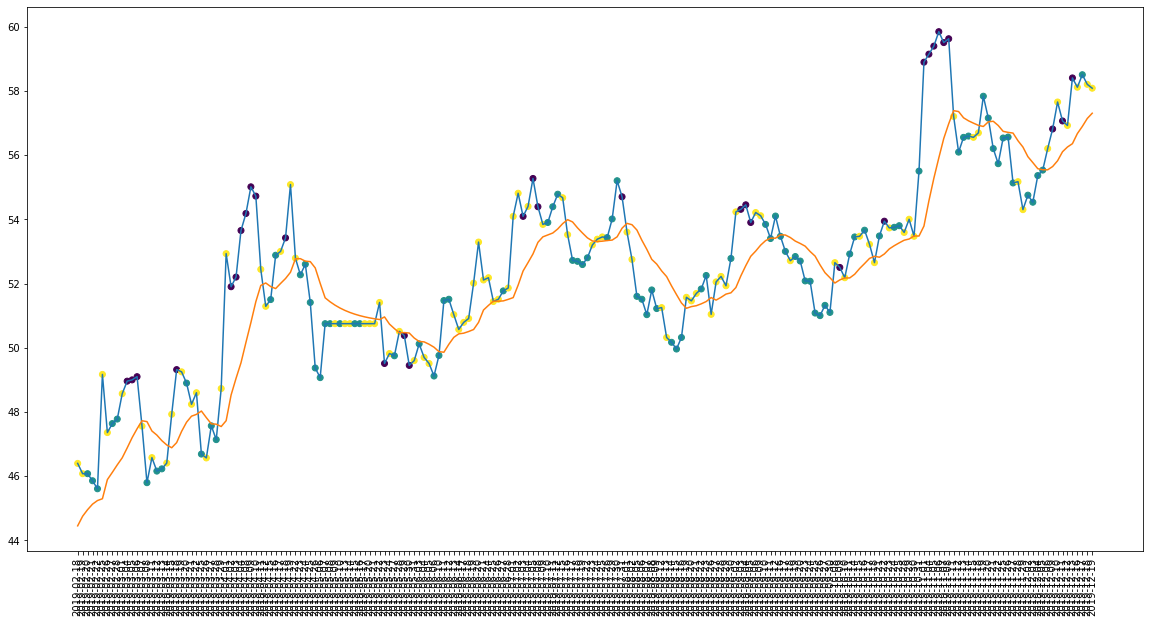

In [108]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [109]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [110]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 78
actual holds but predicted sell: 27
actual predicted holds: 81
Percentage buys correct: 63.63636363636363%
Percentage sells correct: 50.0%
Percentage holds correct: 43.54838709677419%
actual buys: 11
actual sells: 10
actual holds: 186


In [111]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 58.62068965517241%
Percentage sells correct: 62.5%
Percentage holds correct: 81.60919540229885%


In [112]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.08000183105469
Shares owned at the moment: 216
Cash capital at the moment: $19.348083404540375


Price increase from previously bought: 5.958607620227463%
Share price: $48.959999084472656
Shares owned at the moment: 0
Cash capital at the moment: $10565.625646194458


Share price: $45.79999923706055
Shares owned at the moment: 230
Cash capital at the moment: $2.6573221530907176


Price increase from previously bought: 7.390267411779328%
Share price: $49.31999969482422
Shares owned at the moment: 0
Cash capital at the moment: $11315.062352155684


Share price: $48.9000015258789
Shares owned at the moment: 230
Cash capital at the moment: $37.13275023841925


Stop Loss Activated!

Share price: $46.68999862670898
Shares owned at the moment: 0
Cash capital at the moment: $10746.30101025009


Share price: $46.68999862670898
Shares owned at the moment: 229
Cash capital at the moment: $24.88829809856361


Price increase from previously bought: 10.853864770599042%
Share price: $

In [113]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


In [114]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys       correct_sells        correct_holds  \
0       0.502415  45.45454545454545%  36.36363636363637%  51.351351351351354%   
1       0.562500  44.44444444444444%               60.0%  56.613756613756614%   
2       0.449275  63.63636363636363%               50.0%   43.54838709677419%   

     correct_low_buys  correct_high_sells   correct_mid_holds  \
0  52.77777777777778%  45.16129032258065%  83.33333333333333%   
1               50.0%  53.03030303030303%  85.21739130434783%   
2  58.62068965517241%               62.5%  81.60919540229885%   

        Profit gained    buy_n_hold profit  
0  32.86137729614245%    53.5836826651001%  
1  36.98065233612054%   66.41259749999998%  
2  33.34410382081023%  24.380335833320625%

#### Recession

In [115]:
logger = []

In [116]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


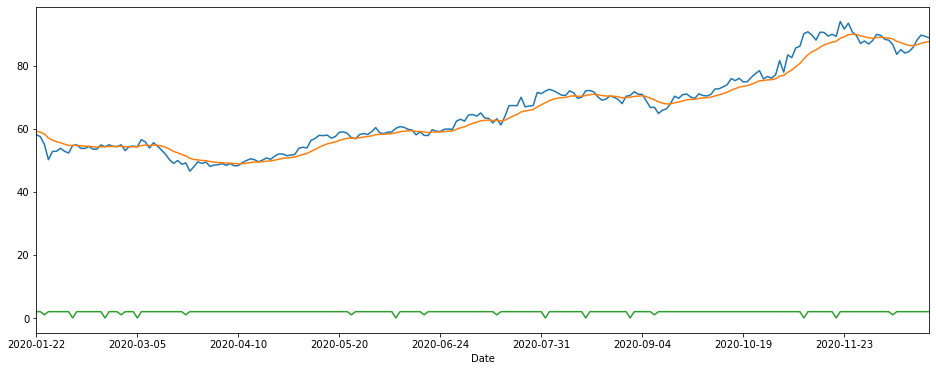

In [117]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

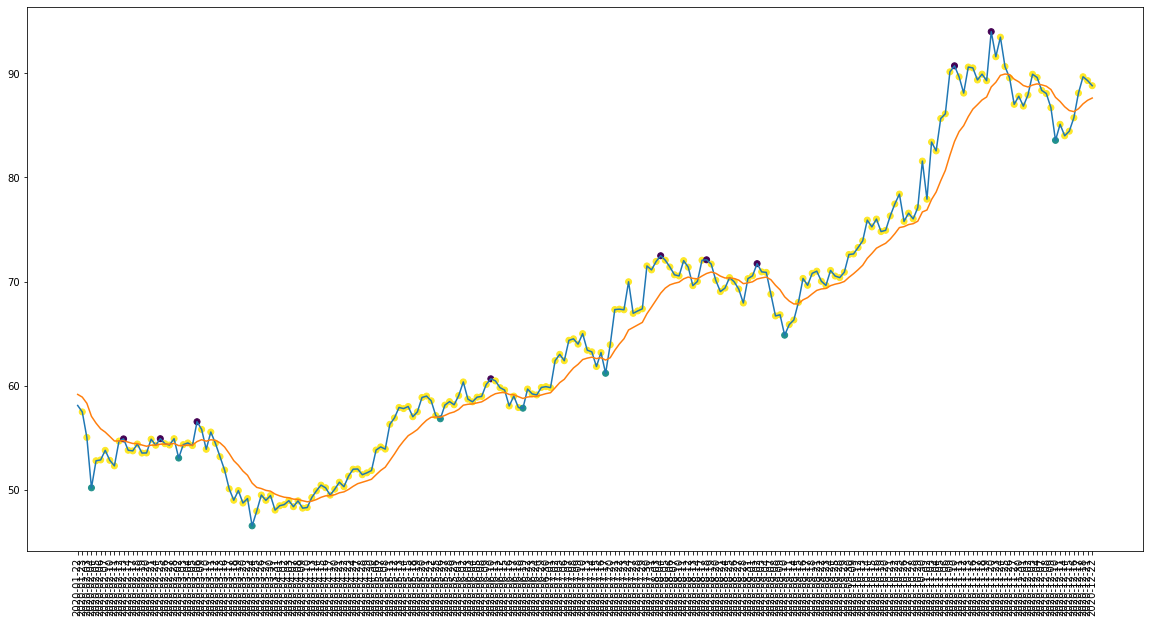

In [118]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [119]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [121]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [122]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [123]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 4ms/step - loss: 0.1850 - accuracy: 0.4615 - mean_squared_error: 1.2184 - weighted_accuracy: 0.4615 - weighted_mean_squared_error: 1.2184
Test loss: 0.18501049280166626
Test accuracy: 0.4615384638309479


In [124]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 93, 0: 42, 1: 73})

In [125]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [126]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [127]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-19    53.540001  54.301035 -52.927131 -33290149.0     2.0   
2020-02-20    54.860001  54.183953 -44.755246  -9557295.0     2.0   
2020-02-21    54.279999  54.287960  -8.665511  27483857.0     2.0   
2020-02-24    54.910000  54.286736 -21.343904  -2296012.0     0.0   
2020-02-25    54.430000  54.382622 -12.602723  38486402.0     2.0   

            predictions  actual  
Date                             
2020-02-19            2       2  
2020-02-20            2       2  
2020-02-21            0       2  
2020-02-24            2       0  
2020-02-25            2       2

In [128]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

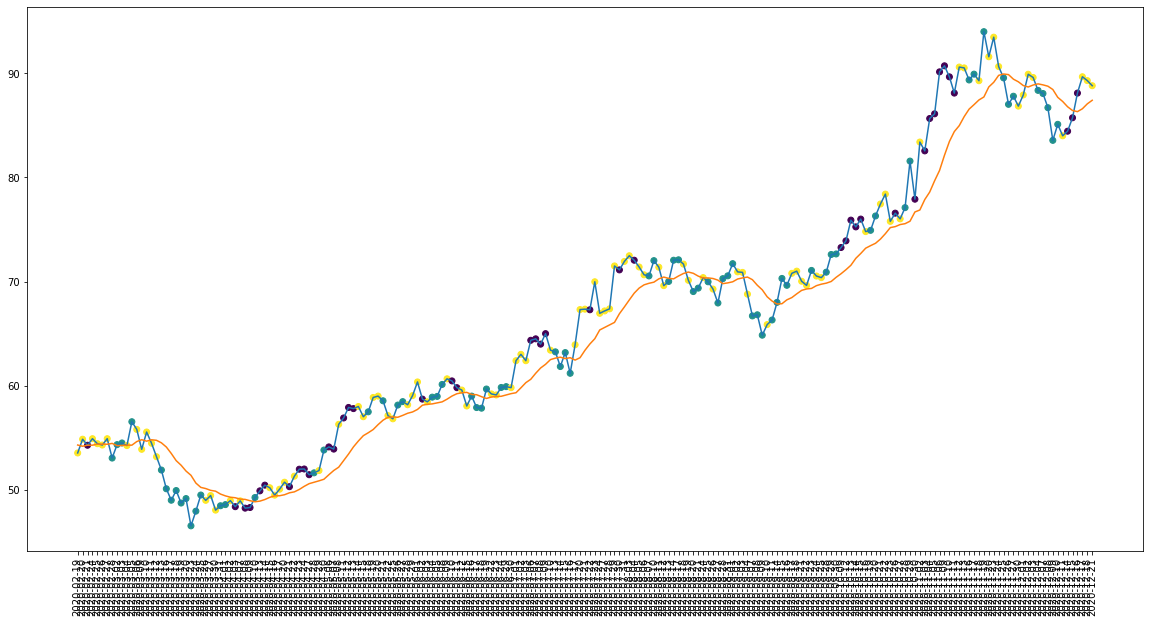

In [129]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

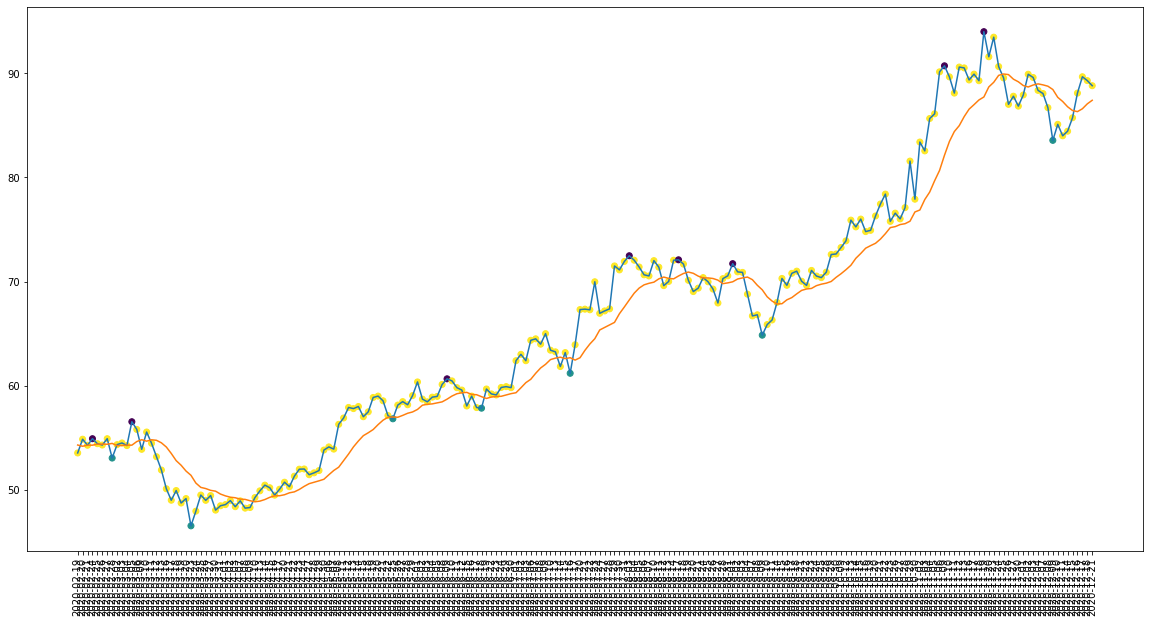

In [130]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [131]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 4
actual predicted sells: 1
actual sells but predicted hold: 3
actual holds but predicted buy: 63
actual holds but predicted sell: 41
actual predicted holds: 89
Percentage buys correct: 85.71428571428571%
Percentage sells correct: 12.5%
Percentage holds correct: 46.1139896373057%
actual buys: 7
actual sells: 8
actual holds: 193


In [132]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 50.68493150684932%
Percentage sells correct: 47.61904761904762%
Percentage holds correct: 84.78260869565217%


In [133]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $53.04999923706055
Shares owned at the moment: 187
Cash capital at the moment: $52.3691805620183


Stop Loss Activated!

Share price: $50.099998474121094
Shares owned at the moment: 0
Cash capital at the moment: $9395.304971007346


Share price: $50.099998474121094
Shares owned at the moment: 187
Cash capital at the moment: $0.8413321313855704


Stop Loss Activated!

Share price: $48.72999954223633
Shares owned at the moment: 0
Cash capital at the moment: $9088.291844264984


Share price: $48.72999954223633
Shares owned at the moment: 185
Cash capital at the moment: $48.450541684151176


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8634.673485590934


Share price: $46.540000915527344
Shares owned at the moment: 185
Cash capital at the moment: $1.096090752600503


Price increase from previously bought: 6.925551947987829%
Share price: $49.9000015258789
Shares owned at the moment: 0
Cash capital at the momen

In [134]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


In [135]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys       correct_sells        correct_holds  \
0       0.502415  45.45454545454545%  36.36363636363637%  51.351351351351354%   
1       0.562500  44.44444444444444%               60.0%  56.613756613756614%   
2       0.449275  63.63636363636363%               50.0%   43.54838709677419%   
3       0.461538  85.71428571428571%               12.5%    46.1139896373057%   

     correct_low_buys  correct_high_sells   correct_mid_holds  \
0  52.77777777777778%  45.16129032258065%  83.33333333333333%   
1               50.0%  53.03030303030303%  85.21739130434783%   
2  58.62068965517241%               62.5%  81.60919540229885%   
3  50.68493150684932%  47.61904761904762%  84.78260869565217%   

        Profit gained    buy_n_hold profit  
0  32.86137729614245%    53.5836826651001%  
1  36.98065233612054%   66.41259749999998%  
2  33.34410382081023%  24.380335833320625%  
3  26.01890942291244%   64.87407351390837%

## Walmart

In [136]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


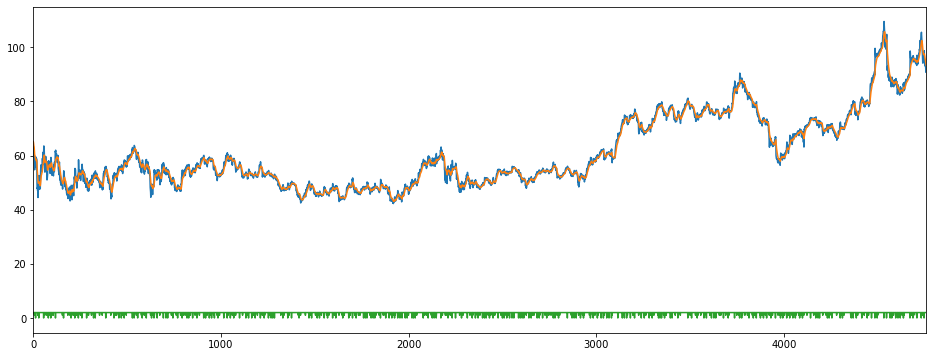

In [137]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [138]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0

In [139]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [140]:
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [142]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

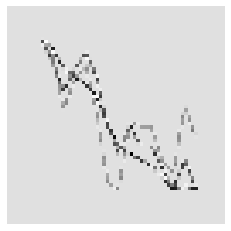

In [143]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [144]:
X = X/255

In [145]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [146]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [147]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [148]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [149]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.148775894538606, 1: 7.3565891472868215, 2: 0.3670824871869258}
Epoch 1/200
30/30 [==============================] - 2s 76ms/step - loss: 0.2443 - accuracy: 0.3775 - mse: 1.5910 - weighted_accuracy: 0.3144 - weighted_mse: 1.7000 - val_loss: 0.2002 - val_accuracy: 0.0506 - val_mse: 0.9210 - val_weighted_accuracy: 0.0506 - val_weighted_mse: 0.9210
Epoch 2/200
30/30 [==============================] - 0s 11ms/step - loss: 0.2064 - accuracy: 0.3425 - mse: 1.1563 - weighted_accuracy: 0.3377 - weighted_mse: 1.1728 - val_loss: 0.2029 - val_accuracy: 0.0527 - val_mse: 0.8581 - val_weighted_accuracy: 0.0527 - val_weighted_mse: 0.8581
Epoch 3/200
30/30 [==============================] - 0s 12ms/step - loss: 0.2034 - accuracy: 0.3886 - mse: 1.1736 - weighted_accuracy: 0.3573 - weighted_mse: 1.1883 - val_loss: 0.2095 - val_accuracy: 0.0464 - val_mse: 0.9030 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.9030
Epoch 4/200
30/30 [==============================] - 0s 11ms/step - loss: 0.204

30/30 [==============================] - 0s 11ms/step - loss: 0.1943 - accuracy: 0.2081 - mse: 1.2107 - weighted_accuracy: 0.4321 - weighted_mse: 1.1994 - val_loss: 0.1997 - val_accuracy: 0.0738 - val_mse: 0.9681 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 0.9681
Epoch 29/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1942 - accuracy: 0.1997 - mse: 1.2445 - weighted_accuracy: 0.4231 - weighted_mse: 1.2003 - val_loss: 0.2039 - val_accuracy: 0.0664 - val_mse: 0.9979 - val_weighted_accuracy: 0.0664 - val_weighted_mse: 0.9979
Epoch 30/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1954 - accuracy: 0.2115 - mse: 1.2400 - weighted_accuracy: 0.4421 - weighted_mse: 1.2239 - val_loss: 0.2057 - val_accuracy: 0.0738 - val_mse: 0.9623 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 0.9623
Epoch 31/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1938 - accuracy: 0.2036 - mse: 1.2076 - weighted_accuracy: 0.4431 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1782 - accuracy: 0.1699 - mse: 1.3197 - weighted_accuracy: 0.4982 - weighted_mse: 1.2428 - val_loss: 0.1956 - val_accuracy: 0.0748 - val_mse: 1.1541 - val_weighted_accuracy: 0.0748 - val_weighted_mse: 1.1541
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1734 - accuracy: 0.1786 - mse: 1.3925 - weighted_accuracy: 0.5502 - weighted_mse: 1.3387 - val_loss: 0.1973 - val_accuracy: 0.0738 - val_mse: 1.1148 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.1148
Epoch 59/200
30/30 [==============================] - 0s 11ms/step - loss: 0.1733 - accuracy: 0.1852 - mse: 1.3301 - weighted_accuracy: 0.5231 - weighted_mse: 1.2800 - val_loss: 0.1961 - val_accuracy: 0.1001 - val_mse: 1.1276 - val_weighted_accuracy: 0.1001 - val_weighted_mse: 1.1276
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1714 - accuracy: 0.1999 - mse: 1.3671 - weighted_accuracy: 0.5436 - 

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1570 - accuracy: 0.2158 - mse: 1.4958 - weighted_accuracy: 0.6096 - weighted_mse: 1.4263 - val_loss: 0.1999 - val_accuracy: 0.1391 - val_mse: 1.3603 - val_weighted_accuracy: 0.1391 - val_weighted_mse: 1.3603
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1552 - accuracy: 0.2144 - mse: 1.5191 - weighted_accuracy: 0.6175 - weighted_mse: 1.4620 - val_loss: 0.1964 - val_accuracy: 0.1486 - val_mse: 1.2973 - val_weighted_accuracy: 0.1486 - val_weighted_mse: 1.2973
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1542 - accuracy: 0.2237 - mse: 1.4963 - weighted_accuracy: 0.6231 - weighted_mse: 1.4562 - val_loss: 0.1973 - val_accuracy: 0.1444 - val_mse: 1.3476 - val_weighted_accuracy: 0.1444 - val_weighted_mse: 1.3476
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1564 - accuracy: 0.2163 - mse: 1.5177 - weighted_accuracy: 0.5986 - wei

Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1396 - accuracy: 0.3448 - mse: 1.7001 - weighted_accuracy: 0.6871 - weighted_mse: 1.7618 - val_loss: 0.1937 - val_accuracy: 0.2856 - val_mse: 1.5840 - val_weighted_accuracy: 0.2856 - val_weighted_mse: 1.5840
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1392 - accuracy: 0.3430 - mse: 1.6901 - weighted_accuracy: 0.6758 - weighted_mse: 1.7528 - val_loss: 0.1943 - val_accuracy: 0.2698 - val_mse: 1.5484 - val_weighted_accuracy: 0.2698 - val_weighted_mse: 1.5484
Epoch 117/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1392 - accuracy: 0.3467 - mse: 1.6917 - weighted_accuracy: 0.6805 - weighted_mse: 1.7616 - val_loss: 0.1924 - val_accuracy: 0.2961 - val_mse: 1.5440 - val_weighted_accuracy: 0.2961 - val_weighted_mse: 1.5440
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1413 - accuracy: 0.3572 - mse: 1.6717 - weighted_accuracy: 0.6775 

Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1257 - accuracy: 0.4473 - mse: 1.8892 - weighted_accuracy: 0.7215 - weighted_mse: 2.1796 - val_loss: 0.1726 - val_accuracy: 0.4731 - val_mse: 1.6199 - val_weighted_accuracy: 0.4731 - val_weighted_mse: 1.6199
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1245 - accuracy: 0.4402 - mse: 1.9216 - weighted_accuracy: 0.7350 - weighted_mse: 2.1830 - val_loss: 0.1735 - val_accuracy: 0.4679 - val_mse: 1.6171 - val_weighted_accuracy: 0.4679 - val_weighted_mse: 1.6171
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1201 - accuracy: 0.4579 - mse: 1.9366 - weighted_accuracy: 0.7252 - weighted_mse: 2.2483 - val_loss: 0.1731 - val_accuracy: 0.4636 - val_mse: 1.6397 - val_weighted_accuracy: 0.4636 - val_weighted_mse: 1.6397
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1246 - accuracy: 0.4613 - mse: 1.9065 - weighted_accuracy: 0.7447 -

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1163 - accuracy: 0.5282 - mse: 2.2478 - weighted_accuracy: 0.7551 - weighted_mse: 2.7798 - val_loss: 0.1542 - val_accuracy: 0.6038 - val_mse: 1.8051 - val_weighted_accuracy: 0.6038 - val_weighted_mse: 1.8051
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1128 - accuracy: 0.5587 - mse: 2.1539 - weighted_accuracy: 0.7715 - weighted_mse: 2.6600 - val_loss: 0.1617 - val_accuracy: 0.5743 - val_mse: 1.8418 - val_weighted_accuracy: 0.5743 - val_weighted_mse: 1.8418
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1159 - accuracy: 0.5677 - mse: 2.1598 - weighted_accuracy: 0.7549 - weighted_mse: 2.6173 - val_loss: 0.1629 - val_accuracy: 0.5732 - val_mse: 1.9225 - val_weighted_accuracy: 0.5732 - val_weighted_mse: 1.9225
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1118 - accuracy: 0.5656 - mse: 2.2141 - weighted_accuracy: 0.7669 - 

In [150]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.14026561379432678
Test accuracy: 0.6902002096176147


In [151]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.83882    -0.53398126 -0.3831346 ]
 [-1.4032183  -0.77084535 -0.27046463]
 [-0.90507627 -1.3851731  -0.19133669]
 ...
 [-2.409299   -0.29295117 -0.55093414]
 [-0.14262721 -2.195131   -0.59646094]
 [-0.41784805 -2.2300644  -0.38530055]]


Counter({2: 701, 1: 123, 0: 125})

In [152]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [153]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 12
actual buys but predicted sell: 0
actual buys but predicted hold: 31
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 34
actual holds but predicted buy: 108
actual holds but predicted sell: 118
actual predicted holds: 636
Percentage buys correct: 27.906976744186046%
Percentage sells correct: 15.909090909090908%
Percentage holds correct: 73.78190255220417%
actual buys: 43
actual sells: 44
actual holds: 862


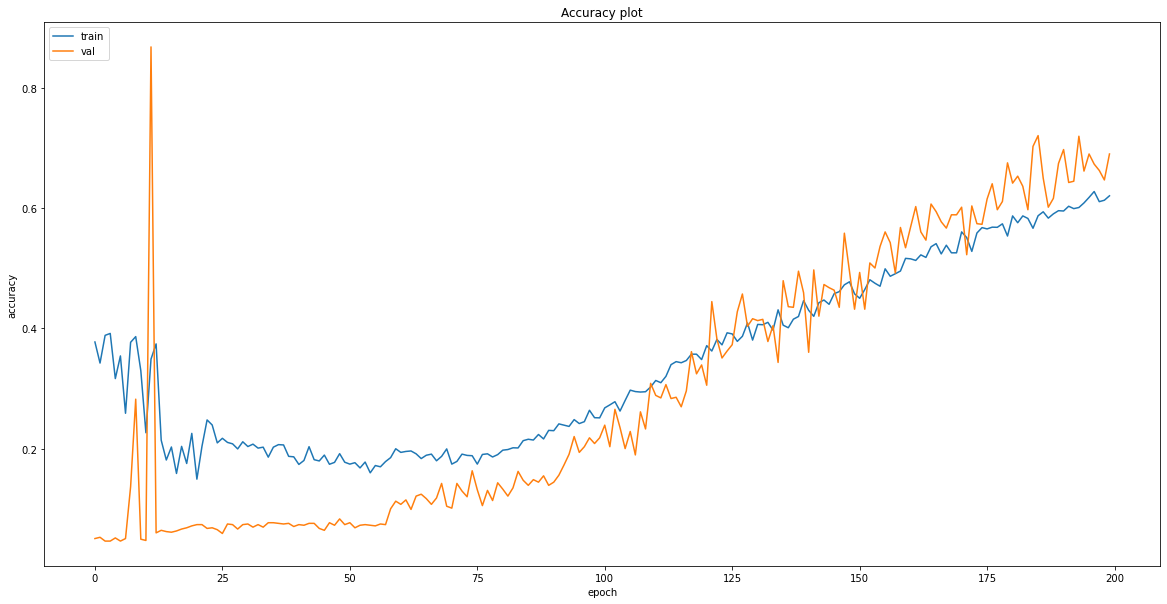

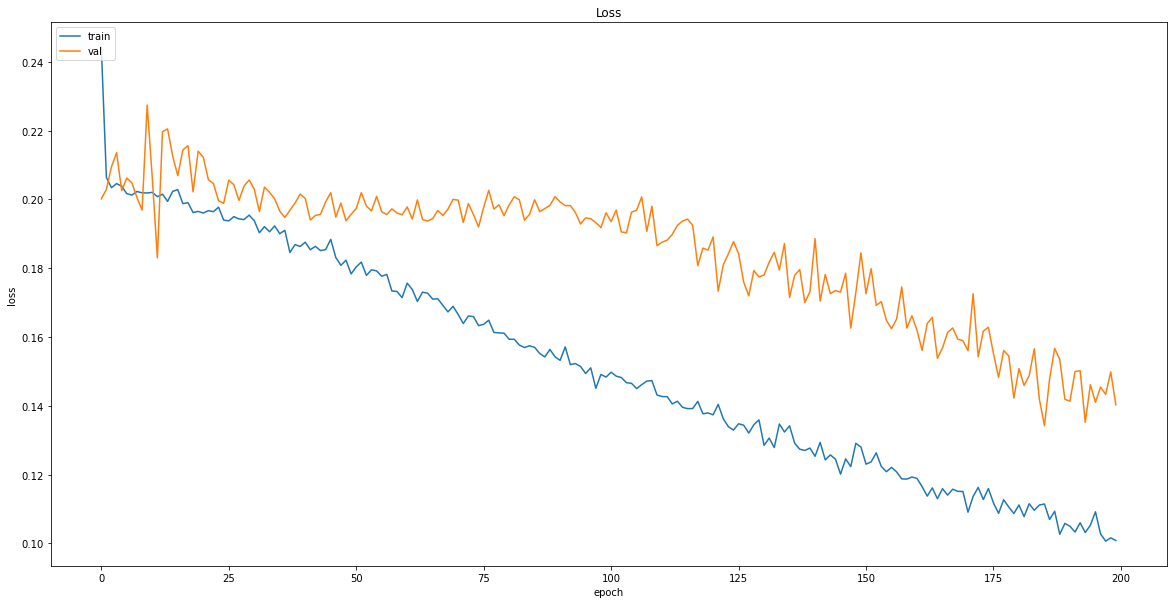

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [155]:
# Save model
model.save("models/{}".format('walmart_image_cnn_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/walmart_image_cnn_buy_hold_sell_no_willr.model\assets


### Test Performance

#### Non-Recession

In [156]:
logger = []

In [157]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


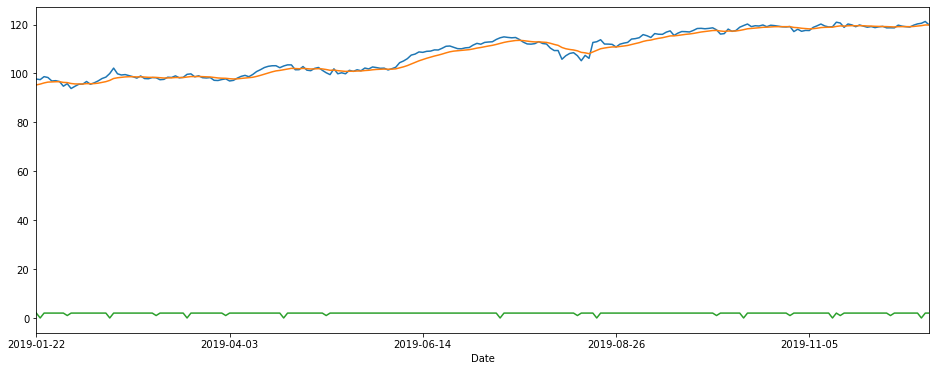

In [158]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [159]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [160]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [161]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [162]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [163]:
model = tf.keras.models.load_model("models/walmart_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 8ms/step - loss: 0.1247 - accuracy: 0.7431 - mean_squared_error: 1.8929 - weighted_accuracy: 0.7431 - weighted_mean_squared_error: 1.8929
Test loss: 0.12474683672189713
Test accuracy: 0.7431192398071289


In [164]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 168, 0: 29, 1: 21})

In [165]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [166]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)

In [167]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11    96.199997  95.814812 -60.416634  53751900.0     2.0   
2019-02-12    96.970001  95.874072 -50.480811  59294700.0     2.0   
2019-02-13    97.940002  96.042676 -33.448300  65176000.0     2.0   
2019-02-14    98.519997  96.334572 -16.724150  70634500.0     2.0   
2019-02-15    99.989998  96.670792 -11.165857  77835300.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            2       2  
2019-02-13            0       2  
2019-02-14            2       2  
2019-02-15            2       2

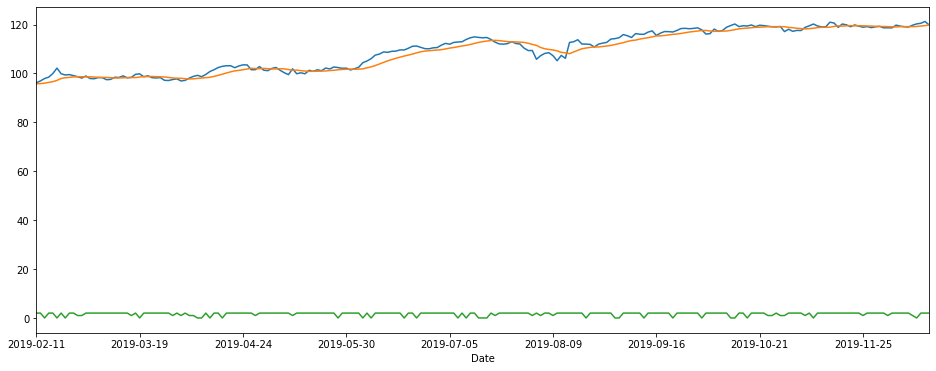

In [168]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

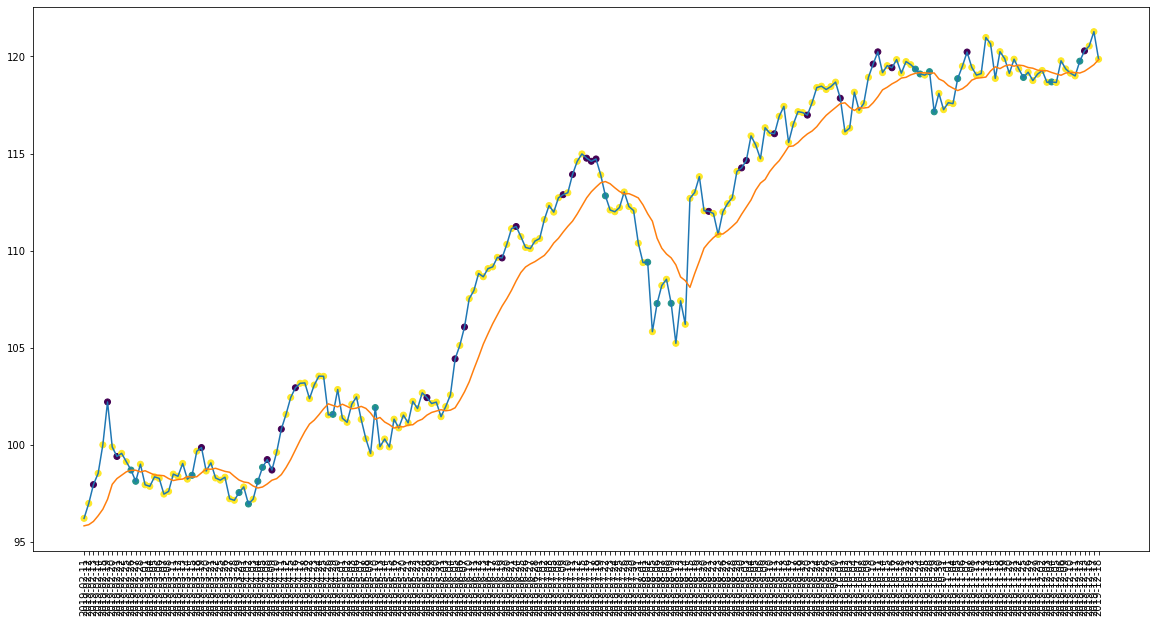

In [169]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

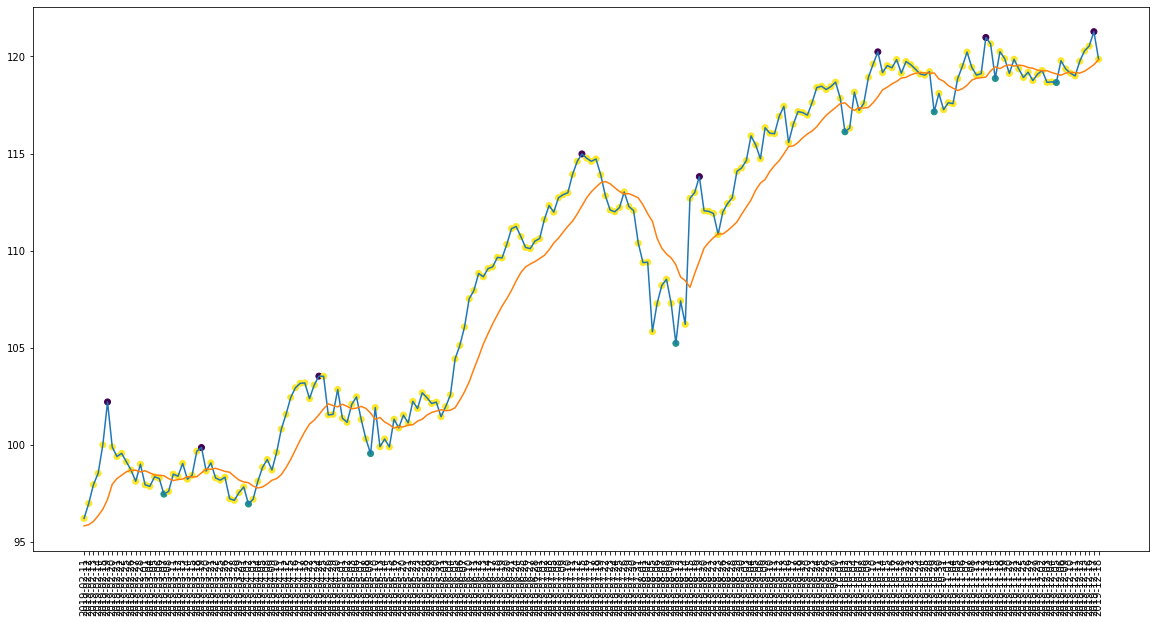

In [170]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [171]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 19
actual holds but predicted sell: 26
actual predicted holds: 157
Percentage buys correct: 25.0%
Percentage sells correct: 37.5%
Percentage holds correct: 77.72277227722772%
actual buys: 8
actual sells: 8
actual holds: 202


In [172]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 44.827586206896555%
Percentage holds correct: 85.62874251497006%


In [173]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.69000244140624
Shares owned at the moment: 101
Cash capital at the moment: $4.898605239870449


Price increase from previously bought: 5.515886217946431%
Share price: $104.41999816894531
Shares owned at the moment: 0
Cash capital at the moment: $10522.315765811922


Share price: $112.81999969482422
Shares owned at the moment: 93
Cash capital at the moment: $1.202079271317416


Stop Loss Activated!

Share price: $109.37999725341795
Shares owned at the moment: 0
Cash capital at the moment: $10145.567889541624


Share price: $109.4000015258789
Shares owned at the moment: 92
Cash capital at the moment: $53.089548774716604


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9761.757060775753


Share price: $107.2699966430664
Shares owned at the moment: 90
Cash capital at the moment: $80.9080387306185


Price increase from previously bought: 6.224156257818758%
Share price: $114.26000213623048
Shares owned at the

In [174]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


In [175]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy        correct_buys       correct_sells        correct_holds  \
0       0.502415  45.45454545454545%  36.36363636363637%  51.351351351351354%   
1       0.562500  44.44444444444444%               60.0%  56.613756613756614%   
2       0.449275  63.63636363636363%               50.0%   43.54838709677419%   
3       0.461538  85.71428571428571%               12.5%    46.1139896373057%   
4       0.743119               25.0%               37.5%   77.72277227722772%   

      correct_low_buys   correct_high_sells   correct_mid_holds  \
0   52.77777777777778%   45.16129032258065%  83.33333333333333%   
1                50.0%   53.03030303030303%  85.21739130434783%   
2   58.62068965517241%                62.5%  81.60919540229885%   
3   50.68493150684932%   47.61904761904762%  84.78260869565217%   
4  57.142857142857146%  44.827586206896555%  85.62874251497006%   

         Profit gained    buy_n_hold profit  
0   32.86137729614245%    53.5836826651001%  
1   36.98065233612054%   66.41259749999998%  
2   33.34410382081023%  24.380335833320625%  
3   26.01890942291244%   64.87407351390837%  
4  3.2331589939498735%    23.7578138288879%

### Recession

In [176]:
logger = []

In [177]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [178]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [179]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [180]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [181]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [182]:
model = tf.keras.models.load_model("models/walmart_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 2ms/step - loss: 0.1378 - accuracy: 0.7078 - mean_squared_error: 1.9754 - weighted_accuracy: 0.7078 - weighted_mean_squared_error: 1.9754
Test loss: 0.13783591985702515
Test accuracy: 0.7077625393867493


In [183]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 165, 1: 25, 0: 29})

In [184]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [185]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)

In [186]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   115.400002  115.836459 -43.516528 -17373100.0     2.0   
2020-02-12   115.849998  115.769312 -40.219793 -11576300.0     2.0   
2020-02-13   117.440002  115.781725 -30.329757  -6840700.0     2.0   
2020-02-14   117.889999  116.036845  -2.057582  -1507500.0     2.0   
2020-02-18   119.629997  116.321946 -14.561040   6623100.0     0.0   

            predictions  actual  
Date                             
2020-02-11            2       2  
2020-02-12            2       2  
2020-02-13            1       2  
2020-02-14            2       2  
2020-02-18            2       0

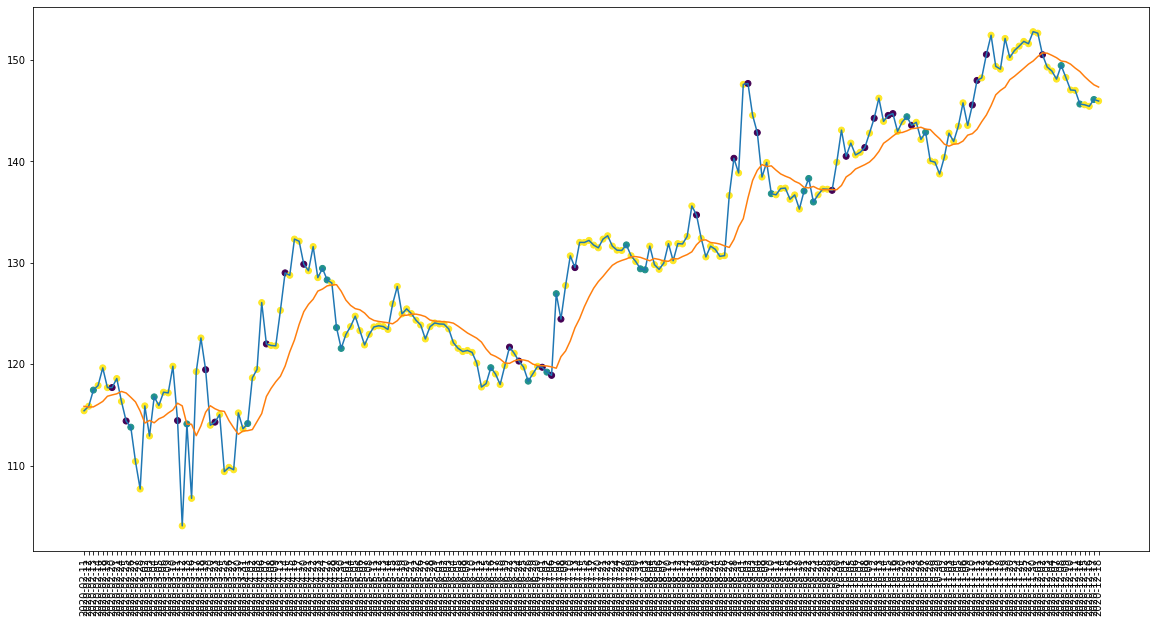

In [187]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

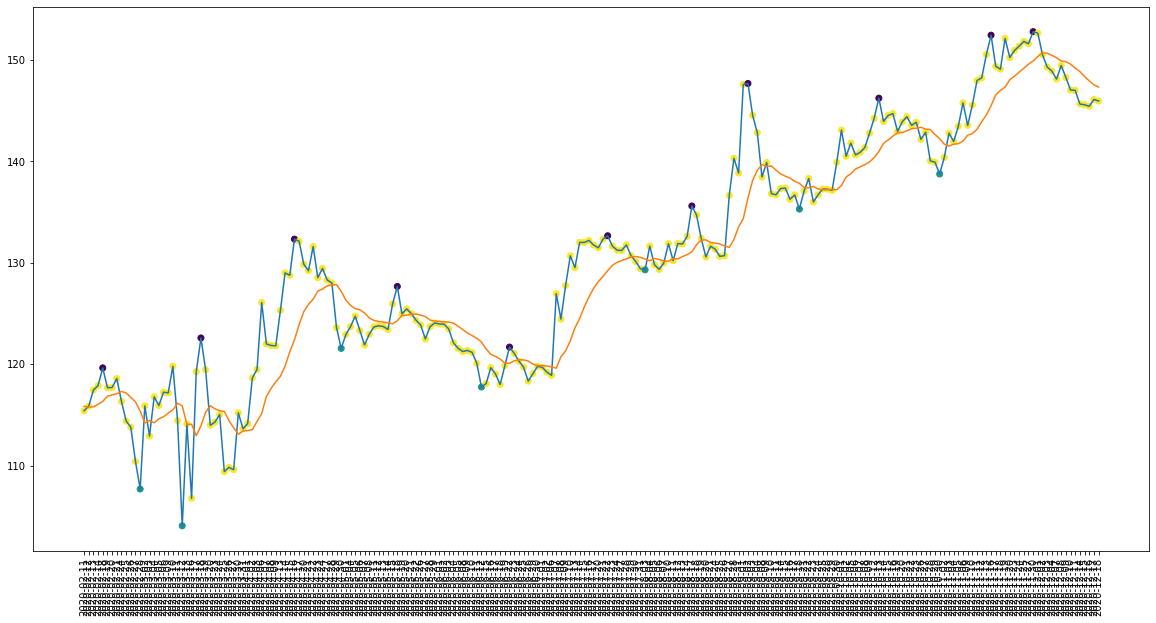

In [188]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [189]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 23
actual holds but predicted sell: 27
actual predicted holds: 151
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 75.12437810945273%
actual buys: 7
actual sells: 11
actual holds: 201


In [190]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 52.0%
Percentage sells correct: 51.724137931034484%
Percentage holds correct: 84.7560975609756%


In [191]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $117.44000244140624
Shares owned at the moment: 84
Cash capital at the moment: $107.91115435791107


Stop Loss Activated!

Share price: $113.77999877929688
Shares owned at the moment: 0
Cash capital at the moment: $9639.147872100832


Share price: $113.77999877929688
Shares owned at the moment: 84
Cash capital at the moment: $55.34479492187711


Stop Loss Activated!

Share price: $110.4000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9303.442522743228


Share price: $116.7699966430664
Shares owned at the moment: 79
Cash capital at the moment: $53.24450617027469


Stop Loss Activated!

Share price: $104.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $8250.589884096145


Share price: $114.0999984741211
Shares owned at the moment: 72
Cash capital at the moment: $12.798194261549725


Stop Loss Activated!

Share price: $106.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $7678.379867647171


Share price: $

In [192]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


In [193]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.502415   45.45454545454545%   36.36363636363637%   
1       0.562500   44.44444444444444%                60.0%   
2       0.449275   63.63636363636363%                50.0%   
3       0.461538   85.71428571428571%                12.5%   
4       0.743119                25.0%                37.5%   
5       0.707763  28.571428571428573%  18.181818181818183%   

         correct_holds     correct_low_buys   correct_high_sells  \
0  51.351351351351354%   52.77777777777778%   45.16129032258065%   
1  56.613756613756614%                50.0%   53.03030303030303%   
2   43.54838709677419%   58.62068965517241%                62.5%   
3    46.1139896373057%   50.68493150684932%   47.61904761904762%   
4   77.72277227722772%  57.142857142857146%  44.827586206896555%   
5   75.12437810945273%                52.0%  51.724137931034484%   

    correct_mid_holds         Profit gained    buy_n_hold profit  
0  83.33333333333333%    32.86137729614245%    53.5836826651001%  
1  85.21739130434783%    36.98065233612054%   66.41259749999998%  
2  81.60919540229885%    33.34410382081023%  24.380335833320625%  
3  84.78260869565217%    26.01890942291244%   64.87407351390837%  
4  85.62874251497006%   3.2331589939498735%    23.7578138288879%  
5   84.7560975609756%  -16.049302606620895%   25.65490331684112%

## Fresh Del Monte Produce Inc

In [194]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


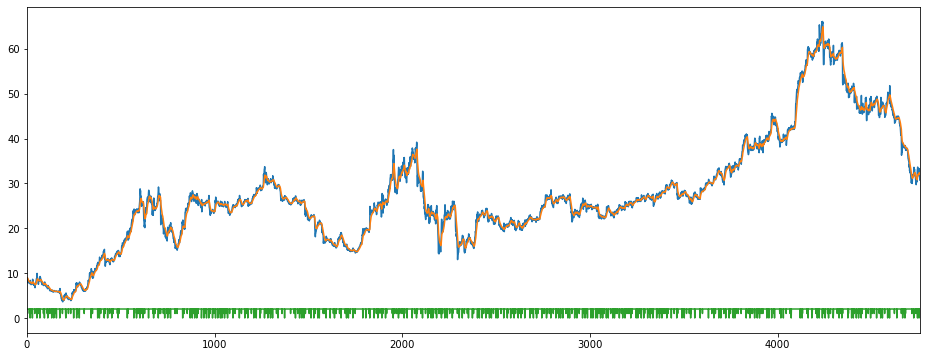

In [195]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [196]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14     OBV_7  labels
Date                                                          
2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0

In [197]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [198]:
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [199]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [200]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

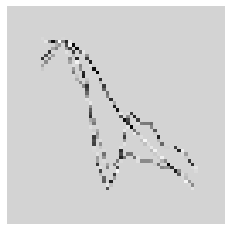

In [201]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [202]:
X = X/255

In [203]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [204]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [205]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [206]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [207]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.1893939393939394, 2: 0.3671890114142}
Epoch 1/200
30/30 [==============================] - 2s 66ms/step - loss: 0.2462 - accuracy: 0.4065 - mse: 1.5868 - weighted_accuracy: 0.3104 - weighted_mse: 1.6961 - val_loss: 0.1995 - val_accuracy: 0.1033 - val_mse: 0.9856 - val_weighted_accuracy: 0.1033 - val_weighted_mse: 0.9856
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2049 - accuracy: 0.3846 - mse: 1.1695 - weighted_accuracy: 0.3488 - weighted_mse: 1.1959 - val_loss: 0.2109 - val_accuracy: 0.0453 - val_mse: 0.8419 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.8419
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2039 - accuracy: 0.3749 - mse: 1.1719 - weighted_accuracy: 0.3363 - weighted_mse: 1.1829 - val_loss: 0.2115 - val_accuracy: 0.0453 - val_mse: 0.8418 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.8418
Epoch 4/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2040 - a

30/30 [==============================] - 0s 9ms/step - loss: 0.1973 - accuracy: 0.2392 - mse: 1.1754 - weighted_accuracy: 0.3753 - weighted_mse: 1.1583 - val_loss: 0.1992 - val_accuracy: 0.0611 - val_mse: 1.0033 - val_weighted_accuracy: 0.0611 - val_weighted_mse: 1.0033
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1963 - accuracy: 0.2508 - mse: 1.2091 - weighted_accuracy: 0.3977 - weighted_mse: 1.1813 - val_loss: 0.2003 - val_accuracy: 0.0622 - val_mse: 0.9896 - val_weighted_accuracy: 0.0622 - val_weighted_mse: 0.9896
Epoch 30/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1975 - accuracy: 0.2468 - mse: 1.1892 - weighted_accuracy: 0.3871 - weighted_mse: 1.1651 - val_loss: 0.2004 - val_accuracy: 0.0632 - val_mse: 0.9540 - val_weighted_accuracy: 0.0632 - val_weighted_mse: 0.9540
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1973 - accuracy: 0.2342 - mse: 1.1872 - weighted_accuracy: 0.3552 - weighted_mse: 1.

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1846 - accuracy: 0.1560 - mse: 1.2504 - weighted_accuracy: 0.4730 - weighted_mse: 1.2035 - val_loss: 0.1967 - val_accuracy: 0.0717 - val_mse: 1.0503 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 1.0503
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1824 - accuracy: 0.1552 - mse: 1.2480 - weighted_accuracy: 0.4944 - weighted_mse: 1.2244 - val_loss: 0.1963 - val_accuracy: 0.0738 - val_mse: 1.0978 - val_weighted_accuracy: 0.0738 - val_weighted_mse: 1.0978
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1817 - accuracy: 0.1475 - mse: 1.2649 - weighted_accuracy: 0.5043 - weighted_mse: 1.2201 - val_loss: 0.1939 - val_accuracy: 0.0664 - val_mse: 1.1011 - val_weighted_accuracy: 0.0664 - val_weighted_mse: 1.1011
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1809 - accuracy: 0.1549 - mse: 1.2850 - weighted_accuracy: 0.5034 - weig

Epoch 86/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1687 - accuracy: 0.1459 - mse: 1.3555 - weighted_accuracy: 0.5343 - weighted_mse: 1.3016 - val_loss: 0.1990 - val_accuracy: 0.1170 - val_mse: 1.2192 - val_weighted_accuracy: 0.1170 - val_weighted_mse: 1.2192
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1667 - accuracy: 0.1478 - mse: 1.3680 - weighted_accuracy: 0.5586 - weighted_mse: 1.3283 - val_loss: 0.1971 - val_accuracy: 0.1212 - val_mse: 1.1938 - val_weighted_accuracy: 0.1212 - val_weighted_mse: 1.1938
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1657 - accuracy: 0.1491 - mse: 1.3675 - weighted_accuracy: 0.5572 - weighted_mse: 1.3315 - val_loss: 0.1980 - val_accuracy: 0.1191 - val_mse: 1.2462 - val_weighted_accuracy: 0.1191 - val_weighted_mse: 1.2462
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1678 - accuracy: 0.1430 - mse: 1.3496 - weighted_accuracy: 0.5352 - wei

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1519 - accuracy: 0.1999 - mse: 1.5010 - weighted_accuracy: 0.6194 - weighted_mse: 1.4873 - val_loss: 0.1991 - val_accuracy: 0.1644 - val_mse: 1.3965 - val_weighted_accuracy: 0.1644 - val_weighted_mse: 1.3965
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1505 - accuracy: 0.2068 - mse: 1.5091 - weighted_accuracy: 0.6183 - weighted_mse: 1.4959 - val_loss: 0.2010 - val_accuracy: 0.1591 - val_mse: 1.4463 - val_weighted_accuracy: 0.1591 - val_weighted_mse: 1.4463
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1510 - accuracy: 0.2052 - mse: 1.4890 - weighted_accuracy: 0.6269 - weighted_mse: 1.4670 - val_loss: 0.2005 - val_accuracy: 0.1928 - val_mse: 1.5028 - val_weighted_accuracy: 0.1928 - val_weighted_mse: 1.5028
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1539 - accuracy: 0.2155 - mse: 1.4965 - weighted_accuracy: 0.6341 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1369 - accuracy: 0.3190 - mse: 1.7148 - weighted_accuracy: 0.6670 - weighted_mse: 1.8440 - val_loss: 0.1969 - val_accuracy: 0.2424 - val_mse: 1.5492 - val_weighted_accuracy: 0.2424 - val_weighted_mse: 1.5492
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1378 - accuracy: 0.3135 - mse: 1.6902 - weighted_accuracy: 0.6631 - weighted_mse: 1.8216 - val_loss: 0.1942 - val_accuracy: 0.2476 - val_mse: 1.5475 - val_weighted_accuracy: 0.2476 - val_weighted_mse: 1.5475
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1336 - accuracy: 0.3235 - mse: 1.7268 - weighted_accuracy: 0.6903 - weighted_mse: 1.8961 - val_loss: 0.1940 - val_accuracy: 0.2381 - val_mse: 1.5943 - val_weighted_accuracy: 0.2381 - val_weighted_mse: 1.5943
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1375 - accuracy: 0.3380 - mse: 1.6893 - weighted_accuracy: 0.6901 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1282 - accuracy: 0.4220 - mse: 1.9280 - weighted_accuracy: 0.6795 - weighted_mse: 2.2714 - val_loss: 0.1863 - val_accuracy: 0.3857 - val_mse: 1.6753 - val_weighted_accuracy: 0.3857 - val_weighted_mse: 1.6753
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1273 - accuracy: 0.4565 - mse: 1.8510 - weighted_accuracy: 0.6959 - weighted_mse: 2.1992 - val_loss: 0.1902 - val_accuracy: 0.3793 - val_mse: 1.8273 - val_weighted_accuracy: 0.3793 - val_weighted_mse: 1.8273
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1310 - accuracy: 0.4239 - mse: 1.9179 - weighted_accuracy: 0.6676 - weighted_mse: 2.2571 - val_loss: 0.1863 - val_accuracy: 0.3846 - val_mse: 1.7475 - val_weighted_accuracy: 0.3846 - val_weighted_mse: 1.7475
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1270 - accuracy: 0.4413 - mse: 1.9077 - weighted_accuracy: 0.7028 - 

In [208]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.1801449954509735
Test accuracy: 0.449947327375412


In [209]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.12903826 -1.8959494  -0.70151824]
 [ 0.02572609 -2.1503682  -0.7693253 ]
 [-0.5315894  -1.3484321  -0.5695718 ]
 ...
 [ 0.31728092 -2.6786337  -0.89933836]
 [-0.5150721  -1.4258642  -0.57994246]
 [-1.2915007  -0.60000145 -0.4398607 ]]


Counter({0: 186, 1: 326, 2: 437})

In [210]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [211]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 23
actual buys but predicted sell: 3
actual buys but predicted hold: 18
actual sells but predicted buy: 8
actual predicted sells: 10
actual sells but predicted hold: 25
actual holds but predicted buy: 295
actual holds but predicted sell: 173
actual predicted holds: 394
Percentage buys correct: 52.27272727272727%
Percentage sells correct: 23.25581395348837%
Percentage holds correct: 45.707656612529%
actual buys: 44
actual sells: 43
actual holds: 862


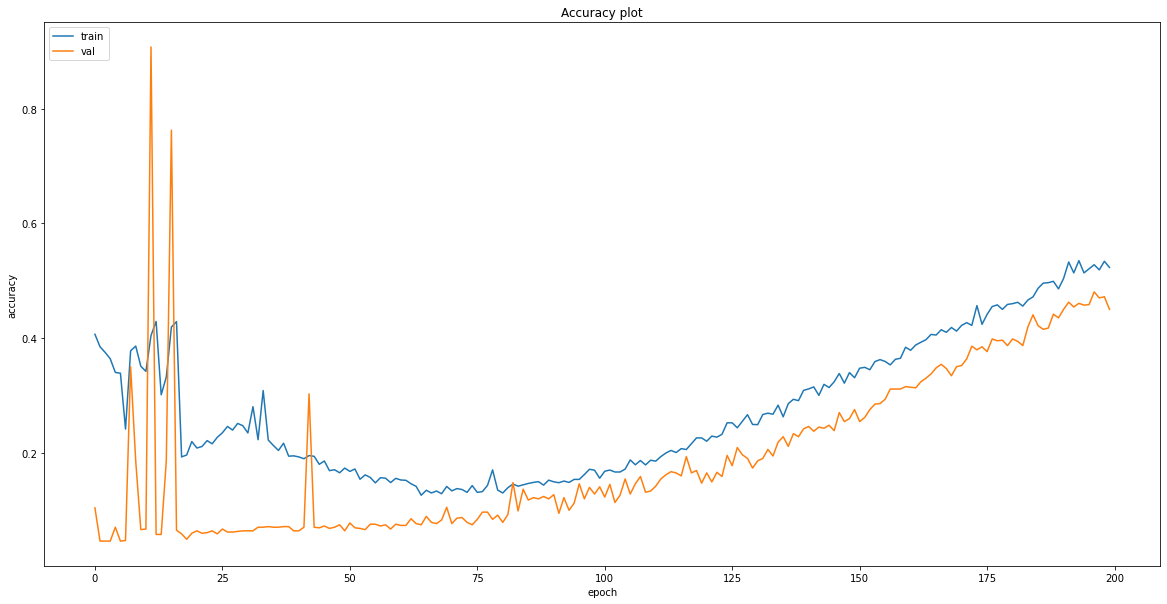

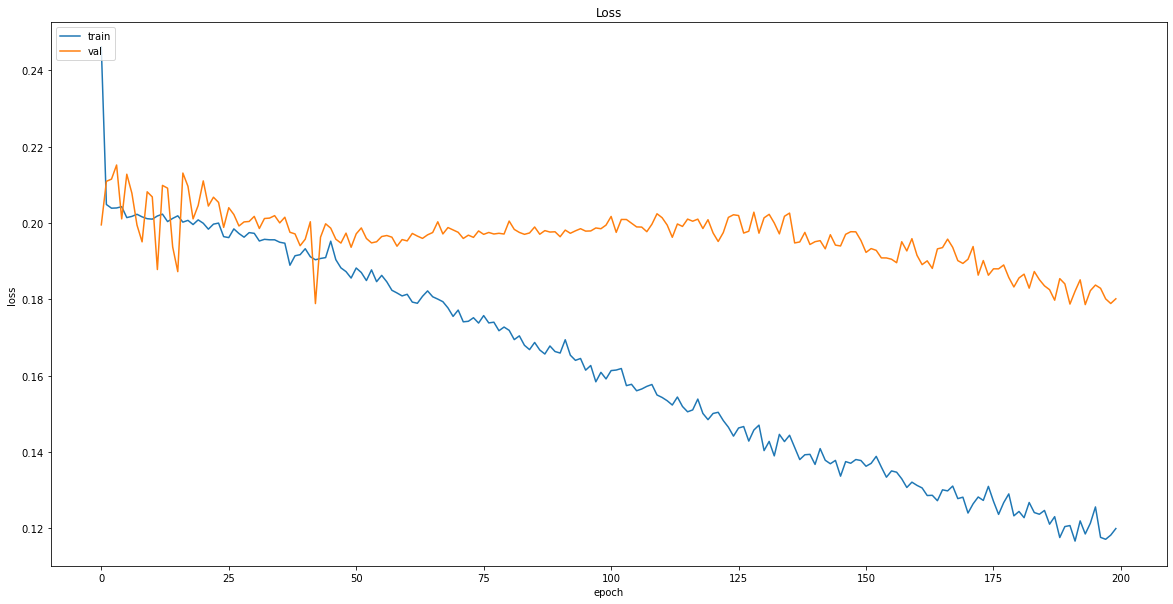

In [212]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [213]:
# Save model
model.save("models/{}".format('FDP_image_cnn_buy_hold_sell_no_willr.model'))

INFO:tensorflow:Assets written to: models/FDP_image_cnn_buy_hold_sell_no_willr.model\assets


### Test Performance

### non-recession

In [214]:
logger = []

In [215]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [216]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [217]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [218]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [219]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [220]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 4ms/step - loss: 0.1747 - accuracy: 0.4862 - mean_squared_error: 1.8729 - weighted_accuracy: 0.4862 - weighted_mean_squared_error: 1.8729
Test loss: 0.17465105652809143
Test accuracy: 0.4862385392189026


In [221]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 110, 0: 39, 1: 69})

In [222]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [223]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)

In [224]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                            
2019-02-11    33.880001  31.978904  -0.753738  2502700.0     2.0            2   
2019-02-12    34.610001  32.271381  -0.536205  2611700.0     2.0            2   
2019-02-13    34.810001  32.631168  -5.603413  2713000.0     2.0            0   
2019-02-14    34.430000  32.966373  -5.668932  2794100.0     2.0            2   
2019-02-15    35.220001  33.191547 -14.285733  2675800.0     0.0            2   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       0

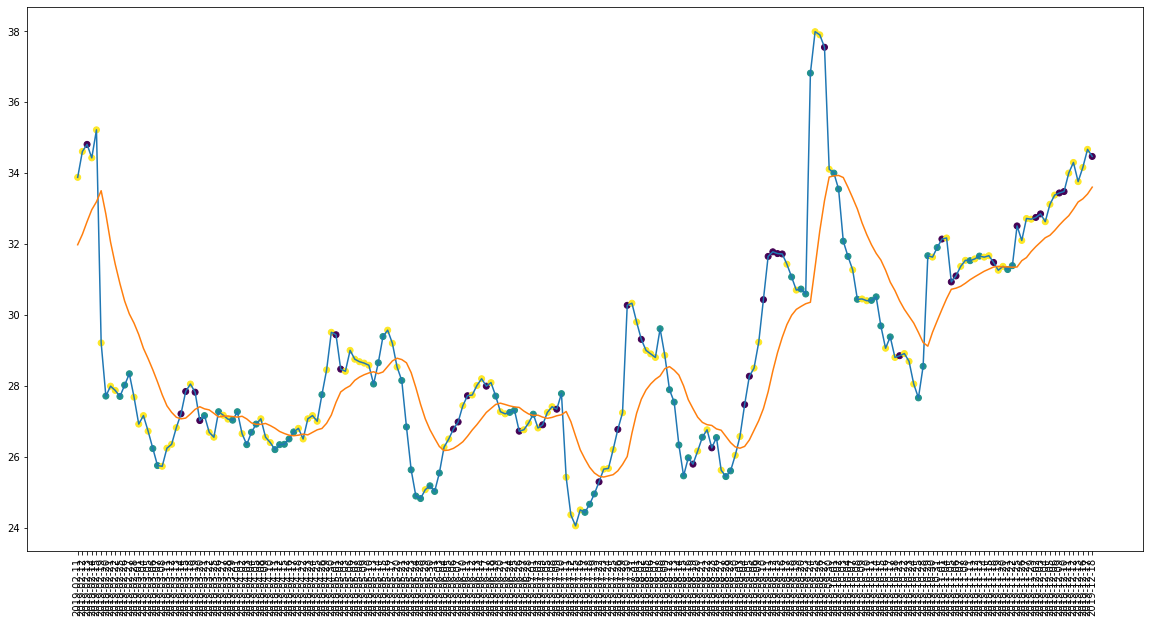

In [225]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

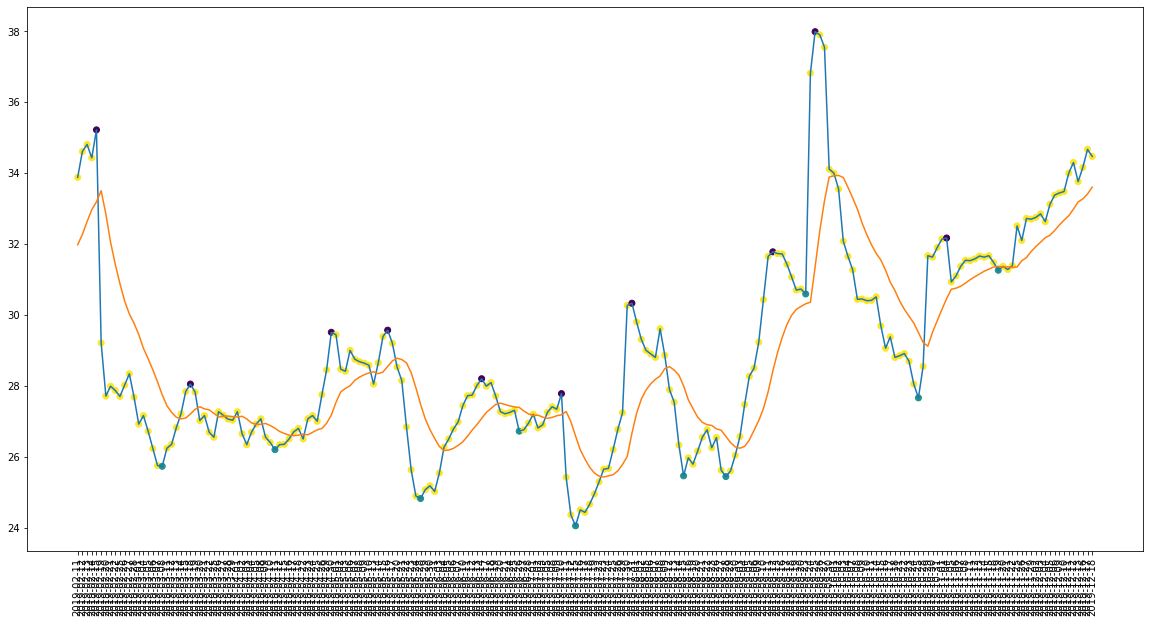

In [226]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [227]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 62
actual holds but predicted sell: 37
actual predicted holds: 99
Percentage buys correct: 60.0%
Percentage sells correct: 10.0%
Percentage holds correct: 50.0%
actual buys: 10
actual sells: 10
actual holds: 198


In [228]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 39.130434782608695%
Percentage sells correct: 48.717948717948715%
Percentage holds correct: 83.4862385321101%


In [229]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.709999084472656
Shares owned at the moment: 359
Cash capital at the moment: $24.753632078170995


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9662.456889392375


Share price: $26.229999542236328
Shares owned at the moment: 367
Cash capital at the moment: $9.574430353641219


Price increase from previously bought: 5.846933279836342%
Share price: $27.84000015258789
Shares owned at the moment: 0
Cash capital at the moment: $10198.756966199397


Share price: $27.15999984741211
Shares owned at the moment: 374
Cash capital at the moment: $12.982963424203263


Stop Loss Activated!

Share price: $26.34000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9837.052330335138


Share price: $26.34000015258789
Shares owned at the moment: 372
Cash capital at the moment: $11.626453416345612


Price increase from previously bought: 11.462651450013528%
Share price: $29.440000534057607
Shares owned a

In [230]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


In [231]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.502415   45.45454545454545%   36.36363636363637%   
1       0.562500   44.44444444444444%                60.0%   
2       0.449275   63.63636363636363%                50.0%   
3       0.461538   85.71428571428571%                12.5%   
4       0.743119                25.0%                37.5%   
5       0.707763  28.571428571428573%  18.181818181818183%   
6       0.486239                60.0%                10.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0  51.351351351351354%   52.77777777777778%   45.16129032258065%   
1  56.613756613756614%                50.0%   53.03030303030303%   
2   43.54838709677419%   58.62068965517241%                62.5%   
3    46.1139896373057%   50.68493150684932%   47.61904761904762%   
4   77.72277227722772%  57.142857142857146%  44.827586206896555%   
5   75.12437810945273%                52.0%  51.724137931034484%   
6                50.0%  39.130434782608695%  48.717948717948715%   

    correct_mid_holds         Profit gained    buy_n_hold profit  
0  83.33333333333333%    32.86137729614245%    53.5836826651001%  
1  85.21739130434783%    36.98065233612054%   66.41259749999998%  
2  81.60919540229885%    33.34410382081023%  24.380335833320625%  
3  84.78260869565217%    26.01890942291244%   64.87407351390837%  
4  85.62874251497006%   3.2331589939498735%    23.7578138288879%  
5   84.7560975609756%  -16.049302606620895%   25.65490331684112%  
6   83.4862385321101%    5.229249576935581%  1.1819906801032993%

### recession

In [232]:
logger = []

In [233]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


In [234]:
#willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
#data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        #data_15_willr_arr = min_max_scaler.fit_transform(#data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        #willr_data.append(#data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        #data_15_willr = #data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        #data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1
        
#willr_data = np.array(#willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [235]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(ema_data)):
    #j = #willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    #ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [236]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [237]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [238]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_no_willr.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.4384 - mean_squared_error: 1.9295 - weighted_accuracy: 0.4384 - weighted_mean_squared_error: 1.9295
Test loss: 0.17964349687099457
Test accuracy: 0.4383561611175537


In [239]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 96, 0: 36, 1: 87})

In [240]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [241]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)

In [242]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels  predictions  \
Date                                                                           
2020-02-11    33.930000  32.680842 -26.373606  310600.0     2.0            2   
2020-02-12    34.410000  32.873020 -19.505473  431300.0     2.0            0   
2020-02-13    34.240002  33.109478 -14.750004  582800.0     2.0            0   
2020-02-14    34.480000  33.283405 -18.999958  490800.0     0.0            1   
2020-02-18    34.009998  33.467496 -13.000011  587800.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       2  
2020-02-13       2  
2020-02-14       0  
2020-02-18       2

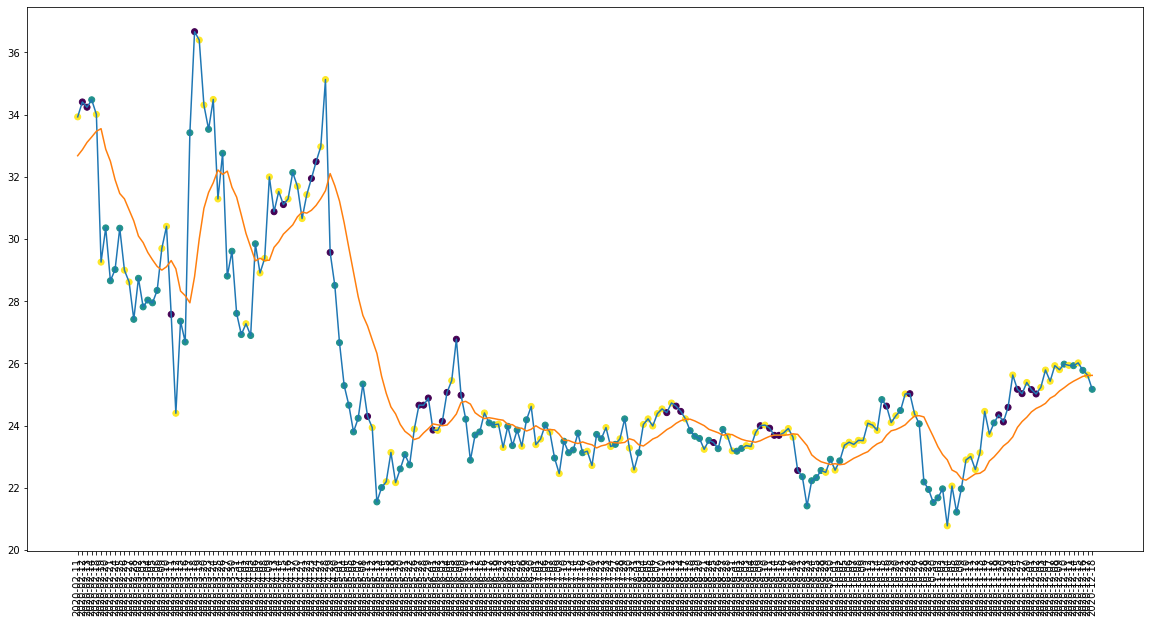

In [243]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

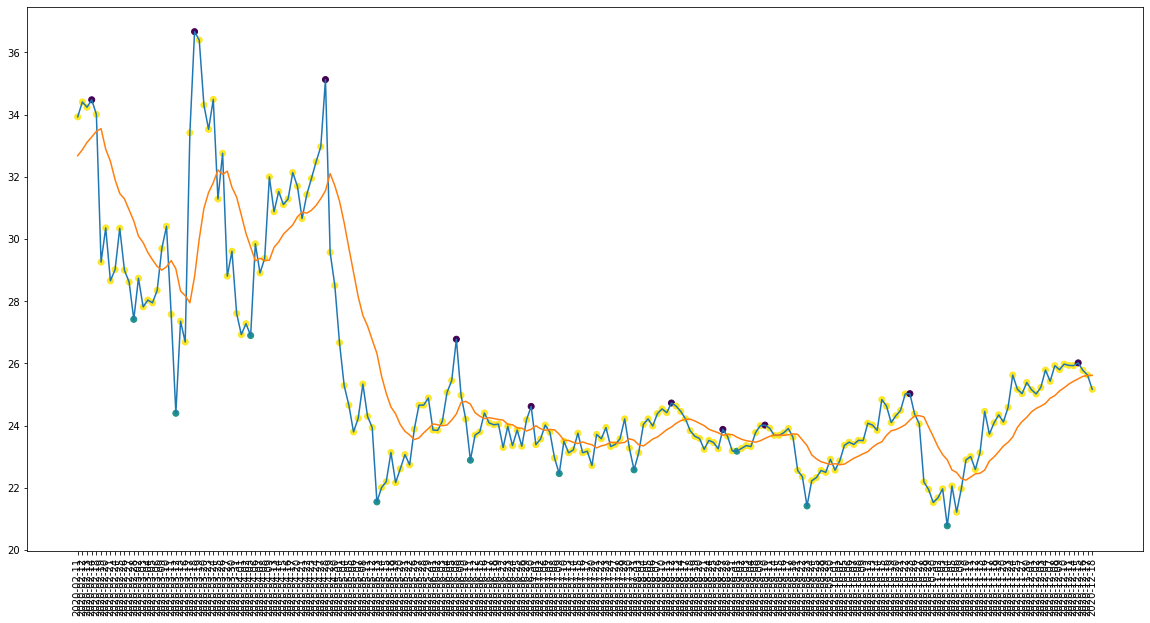

In [244]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [245]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 79
actual holds but predicted sell: 33
actual predicted holds: 87
Percentage buys correct: 60.0%
Percentage sells correct: 30.0%
Percentage holds correct: 43.71859296482412%
actual buys: 10
actual sells: 10
actual holds: 199


In [246]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 52.87356321839081%
Percentage sells correct: 50.0%
Percentage holds correct: 80.0%


In [247]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $34.47999954223633
Shares owned at the moment: 289
Cash capital at the moment: $7.877152657509214


Stop Loss Activated!

Share price: $29.26000022888184
Shares owned at the moment: 0
Cash capital at the moment: $8440.762833622457


Share price: $30.36000061035156
Shares owned at the moment: 277
Cash capital at the moment: $7.915934090140581


Stop Loss Activated!

Share price: $28.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $7924.904136939528


Share price: $28.65999984741211
Shares owned at the moment: 275
Cash capital at the moment: $21.730054016592476


Stop Loss Activated!

Share price: $27.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $7541.49369993973


Share price: $27.420000076293945
Shares owned at the moment: 274
Cash capital at the moment: $7.752708977700422


Stop Loss Activated!

Share price: $24.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $6674.967204742433


Share price: 

In [248]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%


In [249]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.502415   45.45454545454545%   36.36363636363637%   
1       0.562500   44.44444444444444%                60.0%   
2       0.449275   63.63636363636363%                50.0%   
3       0.461538   85.71428571428571%                12.5%   
4       0.743119                25.0%                37.5%   
5       0.707763  28.571428571428573%  18.181818181818183%   
6       0.486239                60.0%                10.0%   
7       0.438356                60.0%                30.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0  51.351351351351354%   52.77777777777778%   45.16129032258065%   
1  56.613756613756614%                50.0%   53.03030303030303%   
2   43.54838709677419%   58.62068965517241%                62.5%   
3    46.1139896373057%   50.68493150684932%   47.61904761904762%   
4   77.72277227722772%  57.142857142857146%  44.827586206896555%   
5   75.12437810945273%                52.0%  51.724137931034484%   
6                50.0%  39.130434782608695%  48.717948717948715%   
7   43.71859296482412%   52.87356321839081%                50.0%   

    correct_mid_holds         Profit gained    buy_n_hold profit  
0  83.33333333333333%    32.86137729614245%    53.5836826651001%  
1  85.21739130434783%    36.98065233612054%   66.41259749999998%  
2  81.60919540229885%    33.34410382081023%  24.380335833320625%  
3  84.78260869565217%    26.01890942291244%   64.87407351390837%  
4  85.62874251497006%   3.2331589939498735%    23.7578138288879%  
5   84.7560975609756%  -16.049302606620895%   25.65490331684112%  
6   83.4862385321101%    5.229249576935581%  1.1819906801032993%  
7               80.0%  -43.750287081255955%  -26.14299892369747%

In [250]:
experiment

'No willr CNN Images Experiments - noncyclic'

In [251]:
log.to_csv('{}.csv'.format(experiment))